<a href="https://colab.research.google.com/github/jpedro-rod/ElementosFinitos/blob/main/M%C3%A9todos_Num%C3%A9ricos_modularizado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Métodos Numéricos

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import scipy as sp
import pandas as pd
import textwrap

##Função que gera domínio e espaçamento
def Dom_h(a, b, pontos):
  DomX = np.linspace(a,b, pontos)
  h = abs(DomX[1]-DomX[0])
  return DomX, h

## Diferenças finitas

### EDOs

**Método explícito**

$A\frac{{d^2\theta(t)}}{{dt^2}} + B\frac{{d\theta(t)}}{{dt}} + Csin(\theta(t)) + r(t) = 0$

$\theta(a) = \theta_0$

$\frac{{d\theta(a)}}{{dt}} = Vo$


Para equações diferenciais não lineares desse tipo, não é possível obter a solução por sistema linear. Para resolvê-la, podemos diminuir a ordem da derivada definindo novas funções e usar um método recursivo. Veja abaixo:

$\frac{{\theta_{{j+1}} - \theta_{{j}}}}{{h}} = v_j  \Leftrightarrow \theta_{{j+1}} = hv_j + \theta_{{j}}$

Onde $v_j$ e $\theta_j$ são condições iniciais. Após essa recorrência, ainda podemos obter a velocidade do corpo ao longo do tempo:

$A\frac{{dv(t)}}{{dt}} + Bv(t) + Csin(\theta(t)) + r(t) = 0$

$Av_{{j+1}} = Av_{{j}} - Bh.v_{{j}} - Ch.sin(\theta_{{j+1}})$


---


**Método Implícito**

$A\frac{{d^2f(t)}}{{dt^2}} + B\frac{{df(t)}}{{dt}} + Cf(t) + r(t) = 0$

$f(t_o) = y_o$, 

$f(t_f) = y_f$


Usando as diferenças finitas centradas de 2 e 3 pontos para a 1ª e 2ª derivadas respectivamente, ter-se-á:

*  $\frac{{df(x)}}{{dx}} \approx \frac{{f(x_{{j+1}})-f(x_{{j-1}})}}{{2h}}$
*  $\frac{{d^2f(x)}}{{dx^2}} \approx \frac{{f(x_{{j+1}})-2f(x_j)+f(x_{{j-1}})}}{{h^2}}$

Onde h é espaçamento da sua malha. Em seguida, ao discretizar a equação diferencial e agrupar os coeficientes de cada termo $f_{{j-1}}$, $f_{{j}}$ e $f_{{j+1}}$, obtem-se a seguinte equação do nó geral:

*  $(2A - Bh).f_{{j-1}} + (-4A + 2Ch^2).f_{{j}} + (2A + Bh).f_{{j+1}} = -2h^2.r(x_j)$

Com os coeficientes dessas variáveis será montado a matriz de coeficientes de um sistema linear. Perceba ainda que a função conhecida r(x) fica do outro lado da equação, onde será o vetor dos termos independentes.

**Diferença explícita**

In [23]:
def dif_explicita(A, B, C, r, to, tf, pontos, theta0, v0):

  Domt, dt = Dom_h(to, tf, pontos)
  Sol_theta = np.empty(Domt.shape)
  Sol_v = np.empty(Domt.shape)
  
  theta = theta0
  v = v0

#Adicionando os valores de contorno aos vetores-solução

  Sol_theta[0] = theta0
  Sol_v[0] = v0

  for i,t in enumerate(Domt[1:], start=1):

    theta = theta + dt*v
    Sol_theta[i] = theta

    v = v - (B(t)*dt/A(t))*v - (C(t)*dt/A(t))*np.sin(theta) - r(t)/A(t)
    Sol_v[i] = v

  return Domt, Sol_theta, Sol_v

**Diferença implícita**

In [24]:
#M.X = I

##Vetor de termos independentes (função que gera I)###################

def gerarI(DomX, h, A, B, ya, yb, r):
  I = np.empty(DomX.size - 2)

  #É necessário adicionar os valores de contorno conhecidos ao vetor B:

  a_index = 0
  b_index = -1

  #É dado que y(a)=ya e y(b)=yb, ou seja, y(X[a_index])=ya e y(X[b_index])=yb    

  I[a_index] = -(2*A(DomX[a_index]) - B(DomX[a_index])*h)*ya - 2*h**2*r(a_index)
  I[b_index] = -(2*A(DomX[b_index]) + B(DomX[b_index])*h)*yb - 2*h**2*r(b_index)
  
  for indice in range(1,len(DomX) - 3):
  
    I[indice] = -2*h**2*r(DomX[indice])   #adicionando os valores de r(x) em B

  return I

#Matriz de coeficientes (função que gera M)############################

def gerarM(DomX, h, A, B, C):
  M = np.zeros([DomX.size - 2,DomX.size -2])

  #Inserindo a primeira e última linhas manualmente:

  M[0,0] = (-4*A(DomX[1]) + 2*C(DomX[1])*h**2)      #primeira linha 
  M[0,1] = (2*A(DomX[2]) + B(DomX[2])*h)

  M[-1,-2] = (2*A(DomX[-3]) - B(DomX[-3])*h)          #última linha
  M[-1,-1] = (-4*A(DomX[-2]) + 2*C(DomX[-2])*h**2)

  #Inserindo as restantes:

  for linha in range(1,len(DomX) - 3):
    M[linha,linha-1] = (2*A(DomX[linha]) - B(DomX[linha])*h)
    M[linha,linha] = (-4*A(DomX[linha]) + 2*C(DomX[linha])*h**2)
    M[linha,linha+1] = (2*A(DomX[linha]) + B(DomX[linha])*h)

  return M

#Função de diferenças finitas (retorna domínio e imagem)###############

def dif_implicita(A, B, C, r, a, b, pontos, ya, yb):
  
  DomX, h = Dom_h(a, b, pontos)
  I = gerarI(DomX, h, A, B, ya, yb, r)
  M = gerarM(DomX, h, A, B, C)

  Sol = np.linalg.solve(M,I)
  
  SolO = np.array([ya])
  Solf = np.array([yb])

  Sol = np.concatenate((SolO,Sol,Solf))

  return DomX, Sol

#### Exemplos

**Movimento de uma gota em queda sob arrasto e obtenção de sua velocidade terminal**

$m\frac{{dv(t)}}{{dt}} + bv(t) - mg = 0$

$v(0) = v_0 \;\; (1ª C.C.)$

$bv(t) \leq mg$

$ v(t) \leq \frac{{mg}}{{b}} \;\; ⇔ \;\; v_{lim} = \frac{{mg}}{{b}} \;\; (2ª C.C.)$

Como temos o valor de $mg$, saberemos a velocidade em que as forças entrarão em equilíbrio e o corpo não estará mais acelerado.

Veja ainda que a equação deste problema é da forma:

$B\frac{{dv(x)}}{{dt}} + Cv(t) - r(t) = 0$

---


Para equações diferenciais não lineares desse tipo, não é possível obter a solução por sistema linear. Para resolvê-la, podemos diminuir a ordem da derivada definindo novas funções e usar um método recursivo. Veja abaixo:

$\frac{{dv_j}}{{dt}} = \frac{{v_{{j+1}} - v_{{j}}}}{{h}}$

Onde $v_j$ e $\theta_j$ são condições iniciais. Após essa recorrência, ainda podemos obter a velocidade do corpo ao longo do tempo:

$Bv_{{j+1}} = Bv_{{j}} - Ch.v_{{j}} + h.mg$


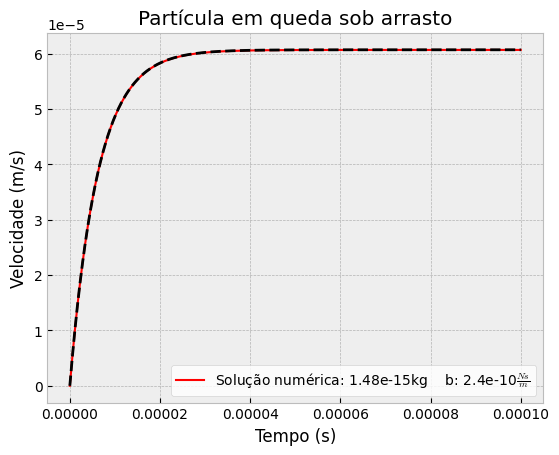

In [4]:
def dif_explicita_gota(m, b, r, to, tf, pontos, v0, vlim):

  Domt, dt = Dom_h(to, tf, pontos)
  Sol_v = np.empty(Domt.shape)

  v = v0

#Adicionando os valores de contorno aos vetores-solução

  Sol_v[0] = v

  for i,t in enumerate(Domt[1:], start=1):

    if v <= vlim:   #A 1ª C.C. já foi usada, agora usamos a 2ª

      v =  (m(t)*v - b(t)*dt*v + dt*r(t))/m(t)
      Sol_v[i] = v

    else: 
      break

  return Domt, Sol_v

#PLOTAGEM################################################

#Parâmetros:
def m(x):
  return 840*(np.pi*(1.5*10**(-6))**3)/6

def b(x):
  return 0.00016*(1.5*10**(-6))

def r(x):
  return 840*((np.pi*(1.5*10**(-6))**3)/6)*9.81

to = 0
tf = 0.0001  #Para a curva aparecer completa o domínio precisar ser maior que 0.0001 (note que vlim ~ 0.00006)
pontos = 10**6
v0 = 0
vlim = 6.0675*10**(-5)

#OBS.: Neste caso não sabemos o instante final (b), saberemos somente pela velocidade final, q ainda será descoberta pela recorrência. Por isso o b colocado é apenas um nº arbitrário

Domt, Sol_v = dif_explicita_gota(m, b, r, to, tf, pontos, v0, vlim)

def f_sol(x):
  return 0*np.exp(-b(0)*x/m(0)) + 0.0000607*(1 - np.exp(-b(0)*x/m(0)))

plt.style.use('bmh')

fig, (ax1) = plt.subplots()
    
ax1.plot(Domt, Sol_v, color='red', linewidth=1.5, label=r'Solução numérica: {}kg    b: {}$\frac{{N s}}{{m}}$'.format(np.around(m(0),17),np.around(b(0),17)))
ax1.plot(Domt, f_sol(Domt), 'k--')
ax1.set_title('Partícula em queda sob arrasto')
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Velocidade (m/s)')
ax1.legend(loc='best',facecolor ='w')   #Além de definir a label da curva no plot, para a legenda aparecer é necessário usar este método.

**Movimento oscilatório não linear livre e amortecido**

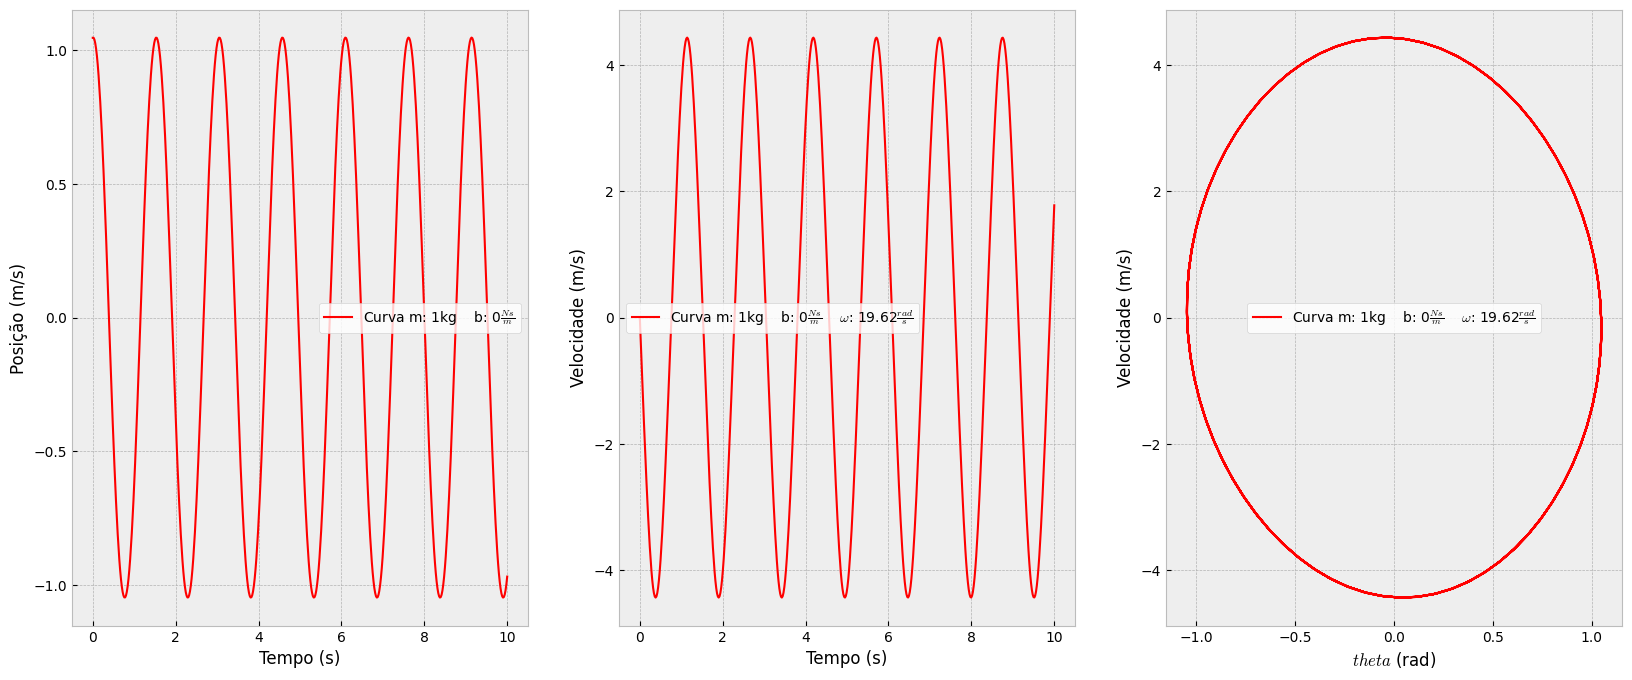

In [5]:

#Parâmetros:
def A(x):
  return 1

def B(x):
  return 0

def C(x):
  return 9.81/0.5

def r(x):
  return 0

to = 0
tf = 10
pontos = 500
theta0 =np.pi/3
v0 = 0

Domt, Sol_theta, Sol_v = dif_explicita(A, B, C, r, to, tf, pontos, theta0, v0)

plt.style.use('bmh')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, sharex = False, figsize = (20,8))
    
ax1.plot(Domt, Sol_theta, color='red', linewidth=1.5, label=r'Curva m: {}kg    b: {}$\frac{{N s}}{{m}}$'.format(A(0),B(0)))
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Posição (m/s)')
ax1.legend(loc='best',facecolor ='w')   #Além de definir a label da curva no plot, para a legenda aparecer é necessário usar este método.

ax2.plot(Domt, Sol_v, color='red', linewidth=1.5, label=r'Curva m: {}kg    b: {}$\frac{{N s}}{{m}}$    $\omega$: {}$\frac{{rad}}{{s}}$'.format(A(0),B(0),C(0)))
ax2.set_xlabel('Tempo (s)')
ax2.set_ylabel('Velocidade (m/s)')
ax2.legend(loc='best',facecolor ='w')

ax3.plot(Sol_theta, Sol_v, color='red', linewidth=1.5, label=r'Curva m: {}kg    b: {}$\frac{{N s}}{{m}}$    $\omega$: {}$\frac{{rad}}{{s}}$'.format(A(0),B(0),C(0)))
ax3.set_xlabel('$theta$ (rad)')
ax3.set_ylabel('Velocidade (m/s)')
ax3.legend(loc='best',facecolor ='w')

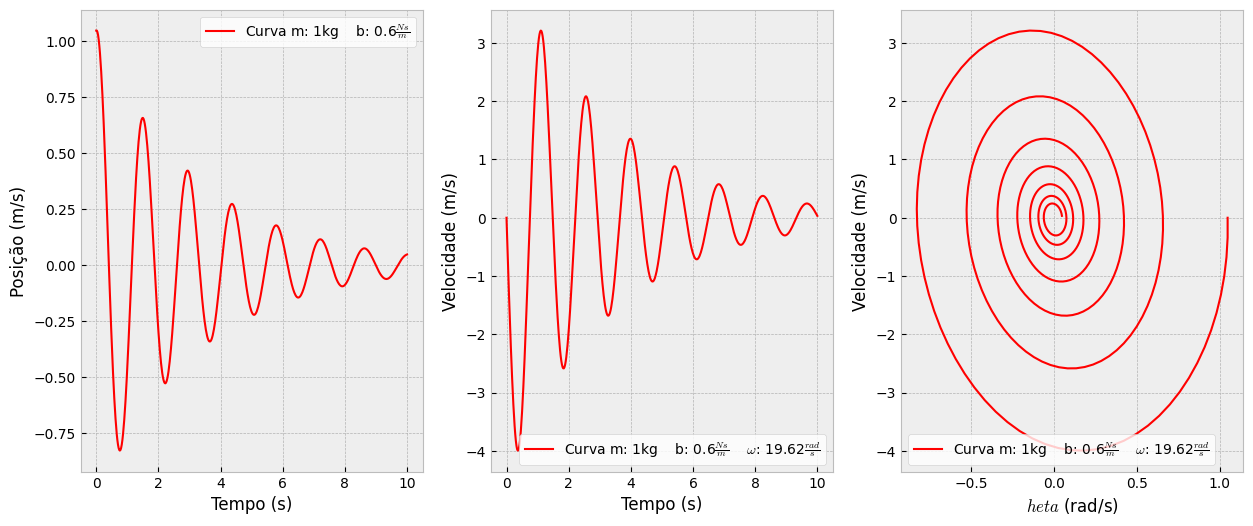

In [6]:
#Parâmetros:
def A(x):
  return 1

def B(x):
  return 0.6

def C(x):
  return 9.81/0.5

def r(x):
  return 0

to = 0
tf = 10
pontos = 500
theta0 =np.pi/3
v0 = 0

Domt, Sol_theta, Sol_v = dif_explicita(A, B, C, r, to, tf, pontos, theta0, v0)

plt.style.use('bmh')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, sharex = False, figsize = (15,6))
    
ax1.plot(Domt, Sol_theta, color='red', linewidth=1.5, label=r'Curva m: {}kg    b: {}$\frac{{N s}}{{m}}$'.format(1,B(0)))
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Posição (m/s)')
ax1.legend(loc='best',facecolor ='w')   #Além de definir a label da curva no plot, para a legenda aparecer é necessário usar este método.

ax2.plot(Domt, Sol_v, color='red', linewidth=1.5, label=r'Curva m: {}kg    b: {}$\frac{{N s}}{{m}}$    $\omega$: {}$\frac{{rad}}{{s}}$'.format(1,B(0),C(0)))
ax2.set_xlabel('Tempo (s)')
ax2.set_ylabel('Velocidade (m/s)')
ax2.legend(loc='best',facecolor ='w')

ax3.plot(Sol_theta, Sol_v, color='red', linewidth=1.5, label=r'Curva m: {}kg    b: {}$\frac{{N s}}{{m}}$    $\omega$: {}$\frac{{rad}}{{s}}$'.format(1,B(0),C(0)))
ax3.set_xlabel('$\theta$ (rad/s)')
ax3.set_ylabel('Velocidade (m/s)')
ax3.legend(loc='best',facecolor ='w')

**Lançamento de projétil com arrasto (linear e quadrático):**

$m\frac{{d\overrightarrow{v}(t)}}{{dt}} = \overrightarrow{F}_{drag} - \overrightarrow{F}_{g}$

$m\frac{{dv_x(t)}}{{dt}} = -bv_x(t)$

$m\frac{{dv_y(t)}}{{dt}} = -bv_y(t) - mg$

Caso linear

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


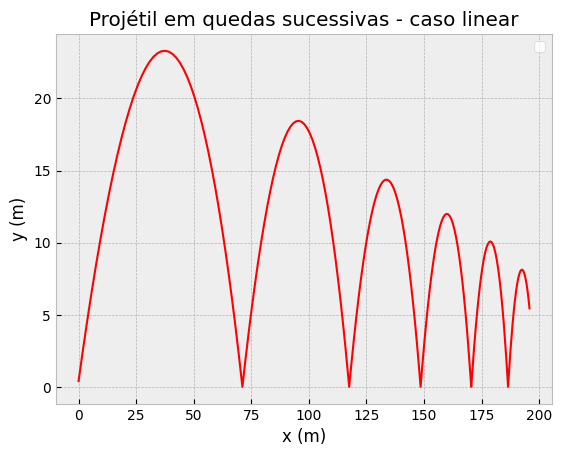

In [7]:
#Parâmetros
m = 0.15
xo = 0
yo = 0.4
vxo = 30*np.cos(np.pi*5/18)
vyo = 30*np.sin(np.pi*5/18)
b = 0.16*7*10**(-2)
c = 0.25*(7*10**(-2))**2
g = 9.81

Domt, dt = Dom_h(0,20,200)

SolX = np.empty(len(Domt))
SolY = np.empty(len(Domt))
SolVx = np.empty(len(Domt))
SolVy = np.empty(len(Domt))

vx = vxo
vy = vyo

x = xo
y = yo

SolX[0] = x
SolY[0] = y
SolVx[0] = vx
SolVy[0] = vy

for i in range(1,len(Domt)):

  vx = vx -(b*dt/m)*vx
  vy = vy -(b*dt/m)*vy - g*dt

  x = x + vx*dt
  y = y + vy*dt

  if y > 0:
    SolX[i] = x
    SolY[i] = y
    SolVx[i] = vx
    SolVy[i] = vy

  elif y == 0:
    SolX[i] = x
    SolY[i] = y
    SolVx[i] = vx
    vy = abs(vy)
    SolVy[i] = vy

  elif y < 0:
    #interpolando
    k = (y-SolY[i-1])/(x-SolX[i-1])
    q = y - k*x                         #NUNCA NOMEIE VARIÁVEIS DENTRO DE UMA FUNÇÃO COM O MESMO NOME DE UM DOS PARÂMETROS DA FUNÇÃO (Ex.: Não use "b" pra constante da reta)
    y = 0
    x = (y - q)/k

    SolX[i] = x
    SolY[i] = y
    SolVx[i] = vx
    vy = abs(vy)
    SolVy[i] = vy

#PLOTAGEM################################################

plt.style.use('bmh')

fig, (ax1) = plt.subplots(1)

ax1.plot(SolX, SolY, color='red', linewidth=1.5)
ax1.set_title('Projétil em quedas sucessivas - caso linear')
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
ax1.legend(loc='best',facecolor ='w')   #Além de definir a label da curva no plot, para a legenda aparecer é necessário usar este método.

Caso quadrático

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


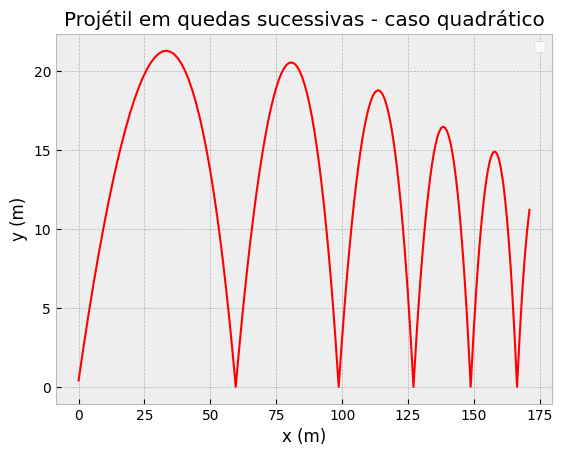

In [9]:
#Parâmetros
m = 0.15
xo = 0
yo = 0.4
vxo = 30*np.cos(np.pi*5/18)
vyo = 30*np.sin(np.pi*5/18)
b = 0.16*7*10**(-2)
c = 0.25*(7*10**(-2))**2
g = 9.81

Domt, dt = Dom_h(0,20,200)

SolX = np.empty(len(Domt))
SolY = np.empty(len(Domt))
SolVx = np.empty(len(Domt))
SolVy = np.empty(len(Domt))

vx = vxo
vy = vyo

x = xo
y = yo

SolX[0] = x
SolY[0] = y
SolVx[0] = vx
SolVy[0] = vy

for i in range(1,len(Domt)):

  vx = vx -(c*dt/m)*vx**2
  vy = vy -(c*dt/m)*vy**2 - g*dt

  x = x + vx*dt
  y = y + vy*dt

  if y > 0:
    SolX[i] = x
    SolY[i] = y
    SolVx[i] = vx
    SolVy[i] = vy

  elif y == 0:
    SolX[i] = x
    SolY[i] = y
    SolVx[i] = vx
    vy = abs(vy)
    SolVy[i] = vy

  elif y < 0:
    #interpolando
    k = (y-SolY[i-1])/(x-SolX[i-1])
    q = y - k*x                         #NUNCA NOMEIE VARIÁVEIS DENTRO DE UMA FUNÇÃO COM O MESMO NOME DE UM DOS PARÂMETROS DA FUNÇÃO (Ex.: Não use "b" pra constante da reta)
    y = 0
    x = (y - q)/k

    SolX[i] = x
    SolY[i] = y
    SolVx[i] = vx
    vy = abs(vy)
    SolVy[i] = vy

#PLOTAGEM################################################

plt.style.use('bmh')

fig, (ax1) = plt.subplots(1)

ax1.plot(SolX, SolY, color='red', linewidth=1.5)
ax1.set_title('Projétil em quedas sucessivas - caso quadrático')
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
ax1.legend(loc='best',facecolor ='w')   #Além de definir a label da curva no plot, para a legenda aparecer é necessário usar este método.

**Oscilador de Van Der Pol**

$\frac{{dv(t)}}{{dt}} - μ(1-x^2)v(t) + x(t)) = 0$

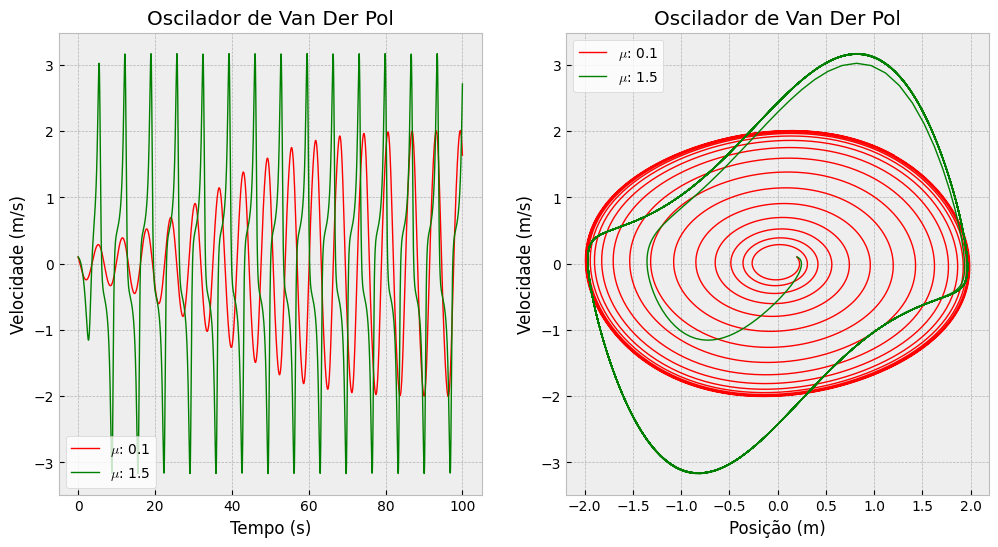

In [11]:
def dif_vanderpol(A, B, C, r, to, tf, pontos, x0, v0, mi):

  Domt, dt = Dom_h(to, tf, pontos)
  Sol_x = np.empty(Domt.shape)
  Sol_v = np.empty(Domt.shape)
  
  x = x0
  v = v0

#Adicionando os valores de contorno aos vetores-solução

  Sol_x[0] = x
  Sol_v[0] = v

  for i,t in enumerate(Domt[1:], start=1):
    x = x + dt*v
    Sol_x[i] = x

    v = v + (B(t)*dt/A(t))*mi*(1-x**2)*v - (C(t)*dt/A(t))*x
    Sol_v[i] = v

  return Domt, Sol_x, Sol_v

#PLOTAGEM################################################

#Parâmetros:
def A(x):
  return 1

def B(x):
  return 1

def C(x):
  return 1

def r(x):
  return 0

to = 0
tf = 100  
pontos = 2000
x0 = 0.2
v0 = 0.1
mi1 = 0.1
mi2 = 0.5
mi3 = 1
mi4 = 1.5

#OBS.: Neste caso não sabemos o instante final (b), saberemos somente pela velocidade final, q ainda será descoberta pela recorrência. Por isso o b colocado é apenas um nº arbitrário

DomX1, Sol_x1, Sol_v1 = dif_vanderpol(A, B, C, r, to, tf, pontos, x0, v0, mi1)
DomX2, Sol_x2, Sol_v2 = dif_vanderpol(A, B, C, r, to, tf, pontos, x0, v0, mi2)
DomX3, Sol_x3, Sol_v3 = dif_vanderpol(A, B, C, r, to, tf, pontos, x0, v0, mi3)
DomX4, Sol_x4, Sol_v4 = dif_vanderpol(A, B, C, r, to, tf, pontos, x0, v0, mi4)

plt.style.use('bmh')

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, sharex = False, figsize = (12,6))
    
ax1.plot(DomX1, Sol_v1, color='red', linewidth=1.0, label=r'$\mu$: {}'.format(mi1))
#ax1.plot(DomX2, Sol_v2, color='blue', linewidth=1.0, label=r'$\mu$: {}'.format(mi2))
#ax1.plot(DomX3, Sol_v3, color='black', linewidth=1.0, label=r'$\mu$: {}'.format(mi3))
ax1.plot(DomX4, Sol_v4, color='green', linewidth=1.0, label=r'$\mu$: {}'.format(mi4))

ax1.set_title('Oscilador de Van Der Pol')
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Velocidade (m/s)')
ax1.legend(loc='best',facecolor ='w')   #Além de definir a label da curva no plot, para a legenda aparecer é necessário usar este método.

ax2.plot(Sol_x1, Sol_v1, color='red', linewidth=1.0, label=r'$\mu$: {}'.format(mi1))
#ax2.plot(Sol_x2, Sol_v2, color='blue', linewidth=1.0, label=r'$\mu$: {}'.format(mi2))
#ax2.plot(Sol_x3, Sol_v3, color='black', linewidth=1.0, label=r'$\mu$: {}'.format(mi3))
ax2.plot(Sol_x4, Sol_v4, color='green', linewidth=1.0, label=r'$\mu$: {}'.format(mi4))

ax2.set_title('Oscilador de Van Der Pol')
ax2.set_xlabel('Posição (m)')
ax2.set_ylabel('Velocidade (m/s)')
ax2.legend(loc='best',facecolor ='w')

**Borboleta de Lorenz**

$\frac{{dx}}{{dt}} = \sigma(y-x)$

$\frac{{dy}}{{dt}} = x(ρ-z)-y$

$\frac{{dz}}{{dt}} = xy-\beta z$

In [16]:
def dif_lorenz(sigma, rho, beta, a, b, pontos, s0):

  Domt, dt = Dom_h(a, b, pontos)
  Sol_x = np.empty(Domt.shape)
  Sol_y = np.empty(Domt.shape)
  Sol_z = np.empty(Domt.shape)
  Sol_vx = np.empty(Domt.shape)
  Sol_vy = np.empty(Domt.shape)
  Sol_vz = np.empty(Domt.shape)

  x0 = s0[0]
  y0 = s0[1]
  z0 = s0[2]

  x = dt*sigma*y0 + (-dt*sigma + 1)*x0
  y = dt*x0*(rho - z0) + (-dt + 1)*y0
  z = dt*x0*y0 - dt*beta*z0 + z0

  vx = sigma*(y - x)
  vy = x*(rho - z) - y
  vz = x*y - beta*z

#Adicionando os valores de contorno aos vetores-solução

  Sol_x[0] = x0
  Sol_x[1] = x
  Sol_y[0] = y0
  Sol_y[1] = y
  Sol_z[0] = z0
  Sol_z[1] = z

  Sol_vx[0] = vx
  Sol_vy[0] = vy
  Sol_vz[0] = vz

  for i in range(2,len(Domt)):

    x = dt*sigma*y + (-dt*sigma + 1)*x
    y = dt*x*(rho - z) + (-dt + 1)*y
    z = dt*x*y - dt*beta*z + z

    Sol_x[i] = x
    Sol_y[i] = y
    Sol_z[i] = z

    vx = sigma*(y - x)
    vy = x*(rho - z) - y
    vz = x*y - beta*z

    Sol_vx[i] = vx
    Sol_vy[i] = vy
    Sol_vz[i] = vz

  return Sol_x, Sol_y, Sol_z, Sol_vx, Sol_vy, Sol_vz

Posição inicial: $S_o = (15, -25, -20)$

Text(0.5, 0, 'z')

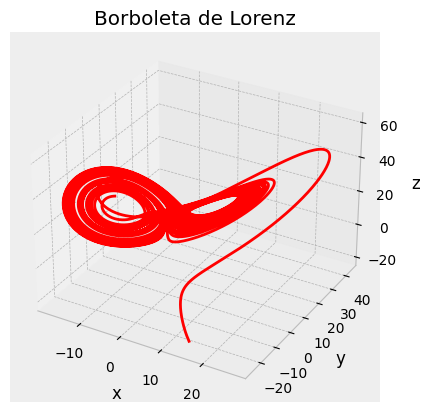

In [14]:
#Parâmetros:
sigma = 10
rho = 28
beta = 8/3
a = 0
b = 50  
pontos = 50000
s2 = [15,-25,-20]

Sol_x1, Sol_y1, Sol_z1, Sol_vx1, Sol_vy1, Sol_vz1 = dif_lorenz(sigma, rho, beta, a, b, pontos, s2)

ax1 = plt.axes(projection="3d")

x1 = Sol_x1
y1 = Sol_y1
z1 = Sol_z1

ax1.plot3D(x1, y1, z1, 'red')
ax1.set_title('Borboleta de Lorenz')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

Posição inicial: $S_o = (14, -26, -21)$

Text(0.5, 0, 'z')

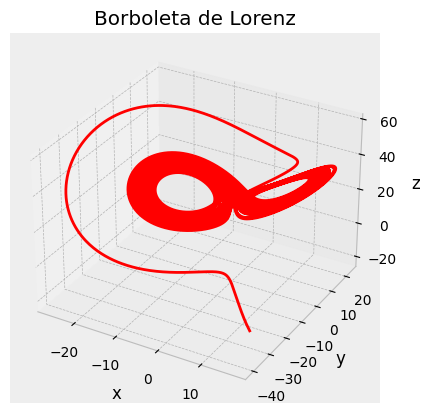

In [15]:
#Parâmetros:
sigma = 10
rho = 28
beta = 8/3
a = 0
b = 50  
pontos = 50000
s2 = [14,-26,-21]

Sol_x2, Sol_y2, Sol_z2, Sol_vx2, Sol_vy2, Sol_vz2 = dif_lorenz(sigma, rho, beta, a, b, pontos, s2)

ax1 = plt.axes(projection="3d")

x2 = Sol_x2
y2 = Sol_y2
z2 = Sol_z2

ax1.plot3D(x2, y2, z2, 'red')
ax1.set_title('Borboleta de Lorenz')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

**Mapa Logístico**

Mais um caso de modelo determinístico que podem ganhar contornos completamente imprevisíveis e caóticos. Este em particula modela o comportamento de uma população:

$x^{n+1} = \mu x^n(1-x_n)$

Onde $x$ é a razão entre a população existente e a máxima população possível em um dado ambiente.

$0 \leq \mu < 1:$ a população morre, independente de $x_0$

$1 \leq \mu < 2:$ a população se aproxima de $\frac{{\mu - 1}}{{\mu}}$, independente de $x_0$

$2 \leq \mu < 3:$ a população se aproxima de $\frac{{\mu - 1}}{{\mu}}$, entretanto mais lentamente

$3 \leq \mu < 1 + 6^{1/2} (3.44949) :$ a população flutuará permanentemente entre dois valores fixos, dependentes do parâmetro $\mu$

$3.44949 \leq \mu < 3.54409 :$ a população flutuará permanentemente entre quatro valores fixos

$\mu \geq 3.54409:$ a população apresenta comportamento caótico. Este ponto é conhecido como o início do
caos.

Text(0, 0.5, 'Razão de população')

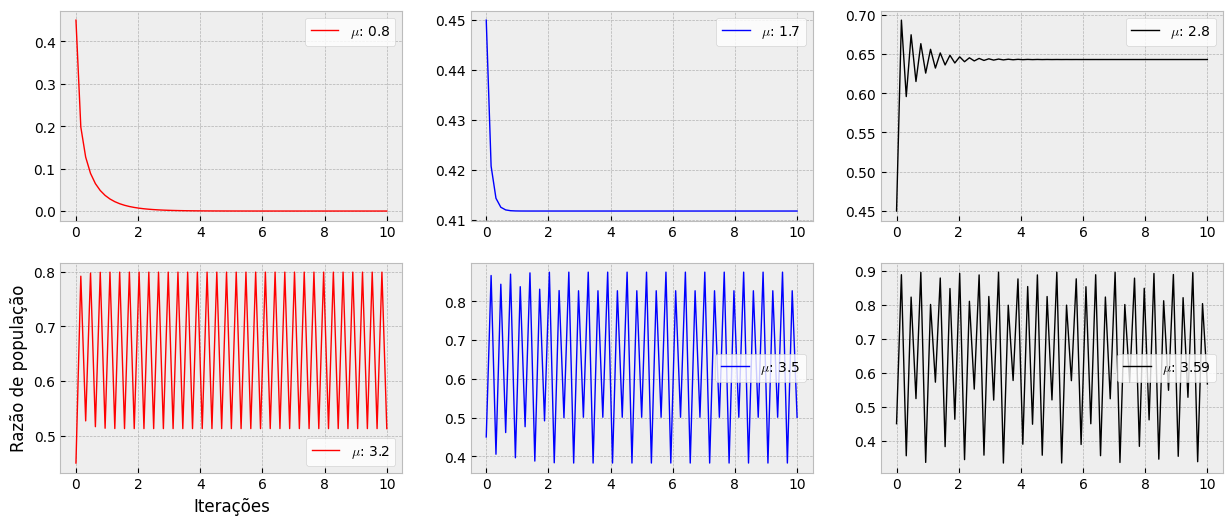

In [20]:
def mapa_logistico(mi,to, tf, pontos, x0):

  Domt, dt = Dom_h(to, tf, pontos)
  Sol_x = np.empty(Domt.shape)

  #x = mi*x0**0*(1 - x0)
  x = x0

#Adicionando os valores de contorno aos vetores-solução

  Sol_x[0] = x

  for i in range(1,len(Domt)):
    #x = mi*x**indice*(1 - x)
    x = mi*x*(1 - x)
    Sol_x[i] = x

  return Domt, Sol_x

#PLOTAGEM################################################

#Parâmetros:

mi = [0.80,1.70,2.80,3.20,3.50,3.59]
a = 0
b = 10  #Para a curva aparecer completa o domínio precisar ser maior que 0.0001 (note que vlim ~ 0.00006)
pontos = 65
x0 = 0.45

Domt1, Sol_x1 = mapa_logistico(mi[0], a, b, pontos, x0)
Domt2, Sol_x2 = mapa_logistico(mi[1], a, b, pontos, x0)
Domt3, Sol_x3 = mapa_logistico(mi[2], a, b, pontos, x0)
Domt4, Sol_x4 = mapa_logistico(mi[3], a, b, pontos, x0)
Domt5, Sol_x5 = mapa_logistico(mi[4], a, b, pontos, x0)
Domt6, Sol_x6 = mapa_logistico(mi[5], a, b, pontos, x0)

#GRÁFICOS DE RAZÃO DE POPULAÇÃO X ITERAÇÕES

plt.style.use('bmh')

fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, sharey=False, sharex = False, figsize = (15,6))
    
ax1.plot(Domt1, Sol_x1, color='red', linewidth=1.0, label=r'$\mu$: {}'.format(mi[0]))
ax2.plot(Domt2, Sol_x2, color='blue', linewidth=1.0, label=r'$\mu$: {}'.format(mi[1]))
ax3.plot(Domt3, Sol_x3, color='black', linewidth=1.0, label=r'$\mu$: {}'.format(mi[2]))
ax4.plot(Domt4, Sol_x4, color='red', linewidth=1.0, label=r'$\mu$: {}'.format(mi[3]))
ax5.plot(Domt3, Sol_x5, color='blue', linewidth=1.0, label=r'$\mu$: {}'.format(mi[4]))
ax6.plot(Domt4, Sol_x6, color='black', linewidth=1.0, label=r'$\mu$: {}'.format(mi[5]))

ax1.legend(loc='best',facecolor ='w')
ax2.legend(loc='best',facecolor ='w')
ax3.legend(loc='best',facecolor ='w')
ax4.legend(loc='best',facecolor ='w')
ax5.legend(loc='best',facecolor ='w')
ax6.legend(loc='best',facecolor ='w')

ax4.set_xlabel('Iterações')
ax4.set_ylabel('Razão de população')

#GRÁFICOS DE RAZÃO DE POPULAÇÃO X MI
#NÃO CONSEGUI FAZER

Movimento de um corpo em movimento retilíneo amortecido via diferenças finitas implícitas:

$m\frac{{dv(t)}}{{dt}} + bv(t) = 0$


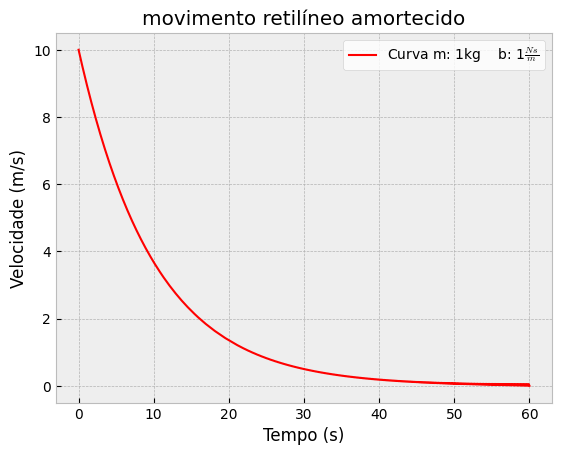

In [25]:
#Parâmetros:
def A(x):
  return 0

def B(x):
  return 1

def C(x):
  return 0.1

def r(x):
  return 0

a1 = 0
b1 = 60
pontos1 = 600
ya1 = 10
yb1 = 0

DomX, Sol = dif_implicita(A, B, C, r, a1, b1, pontos1, ya1, yb1)    #para referenciar funções nos argumentos de outra função, basta escrever seu nome sem parênteses

plt.style.use('bmh')

fig, (ax1) = plt.subplots()
    
ax1.plot(DomX, Sol, color='red', linewidth=1.5, label=r'Curva m: {}kg    b: {}$\frac{{N s}}{{m}}$'.format(1,B(0)))
ax1.set_title('movimento retilíneo amortecido')
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Velocidade (m/s)')
ax1.legend(loc='best',facecolor ='w')   #Além de definir a label da curva no plot, para a legenda aparecer é necessário usar este método.

Solução da equação diferencial não linear genérica via diferenças finitas de MetMat:

A $\frac{{d^2f(t)}}{{dt^2}} + B\frac{{df(t)}}{{dt}} + sin(t)f(t) + r(t) = 0$ onde $\xi = \frac{{B}}{{2A\omega_n}}$, $\omega_n^2 = \frac{{C}}{{A}}$

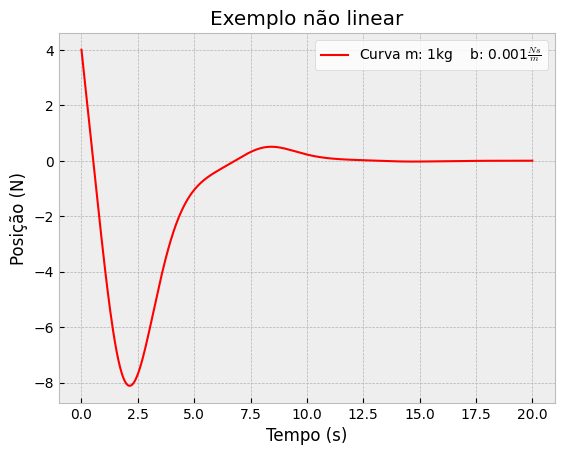

In [27]:
def A(x):
  return 1

def B(x):
  return 0.001

def C(x):
  return np.sin(x)

def r(x):
  return 0

a3 = 0
b3 = 20
pontos3 = 500
ya3 = 4
yb3 =  0

DomX, Sol = dif_implicita(A, B, C, r, a3, b3, pontos3, ya3, yb3)

plt.style.use('bmh')

fig, (ax1) = plt.subplots()
    
ax1.plot(DomX, Sol, color='red', linewidth=1.5, label=r'Curva m: {}kg    b: {}$\frac{{N s}}{{m}}$'.format(A(0),B(0)))
ax1.set_title('Exemplo não linear')
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Posição (N)')
ax1.legend(loc='best',facecolor ='w')   #Além de definir a label da curva no plot, para a legenda aparecer é necessário usar este método.

Equação de Poisson: problema de transferência de calor estacionário

$\alpha\frac{\partial^2 T}{\partial x^2} + Q = 0 \;\; , \;\; \alpha = 0.1 \frac{kJm^2}{K} \;\; , \;\; Q = 0.2 kJ$

$T(x=0) = 0$

$T(x=L) = 1$

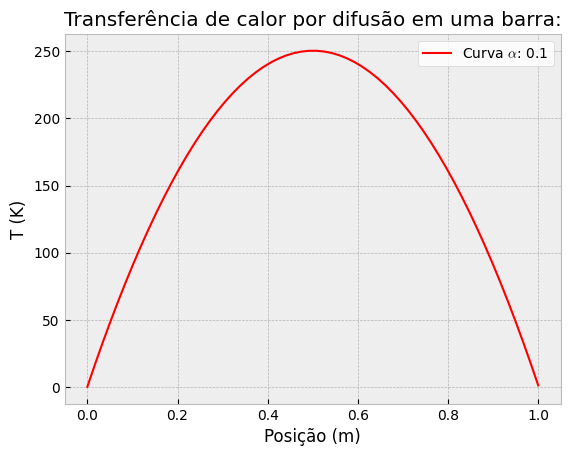

In [28]:
def A(x):
  return 0.1

def B(x):
  return 0

def C(x):
  return 0

def r(x):
  return 200

xo = 0
xf = 1
pontos = 60
To = 0
Tf =  1

DomX, Sol = dif_implicita(A,B,C,r,xo,xf,pontos,To,Tf)

plt.style.use('bmh')

fig, (ax1) = plt.subplots()
    
ax1.plot(DomX, Sol, color='red', linewidth=1.5, label=r'Curva $\alpha$: {}'.format(A(0)))
ax1.set_title('Transferência de calor por difusão em uma barra:')
ax1.set_xlabel('Posição (m)')
ax1.set_ylabel('T (K)')
ax1.legend(loc='best',facecolor ='w')

### EDPs

$A(x,y)\frac{\partial^2 T}{\partial x^2} + B(x,y)\frac{\partial^2 T}{\partial x \partial y} + C(x,y)\frac{\partial^2 T}{\partial y^2} + D(x,y)\frac{\partial T}{\partial x} + E(x,y)\frac{\partial T}{\partial y} + F(x,y)T = G(x,y)$

$B^2 - 4AC < 0:$ Elíptico (problemas dissipativos, associados a processos difusivos estacionários). Ex.: Equação de Poisson

$B^2 - 4AC = 0:$ Parabólico (problemas dissipativos, associados a processos difusivos transientes). Ex.: Equação de calor

$B^2 - 4AC > 0:$ Hiperbólico (problemas advectivos, associados a processos de transporte não-difusivos transientes. Um termo expressando velocidade vem acompanhando uma das derivadas da EDP)

$Problemas \; mistos:$ EDPs parabólicas e hiperbólicas

**Obs.: Convecção = difusão + advecção**

Equação de Poisson (EDP Elíptica):

$\nabla^2 T(x,y) = g(x)$

Equação de Calor (EDP Parabólica):

$\frac{\partial T(x,y,t)}{\partial t} = \alpha \nabla^2 T(x,y,t)$

Equação de Onda (EDP hiperbólica):

$\frac{\partial^2 T(x,y,t)}{\partial t^2} = \lambda^2 \nabla^2 T(x,y,t)$

Problema misto:

$\frac{\partial T(x,t)}{\partial t} + u\frac{\partial T(x,t)}{\partial x} = \alpha \frac{\partial^2 T(x,t)}{\partial x^2}$

Se derivada espacial de 1ª ordem tende a zero, o problema é hiperbólico; se derivada espacial de 2ª ordem tende a zero, problema é parabólico.

#### Problema de transferência de calor transiente (método explícito):

*   Derivada centrada para o espaço e **avançada** para o tempo
*   Recursivo
*   Instável


Neste método temos duas recorrências, para cada N no tempo , haverá uma recorrência para i no espaço. Após obter a temperatura para cada ponto i no instante N, se avança na recorrência no tempo.


Problema de transferência de calor transiente

$\frac{\partial T}{\partial t} = \alpha\frac{\partial^2 T}{\partial x^2} + Q \;\; , \;\; \alpha = 0.1 \frac{kJm^2}{K} \;\; , \;\; Q = 0.2 kJ$

$T(x,t=0) = 0$

$T(x=0,t) = 0$

$T(x=L,t) = 1$

**Obs.: Veja que, ao dar os valores de T nas extremidades de x, não dependemos de nós fictícios para ter os valores de T nessas extremidades e, consequentemente, não dependemos de fluxos prescritos nas condições de contorno**

(10800, 60)


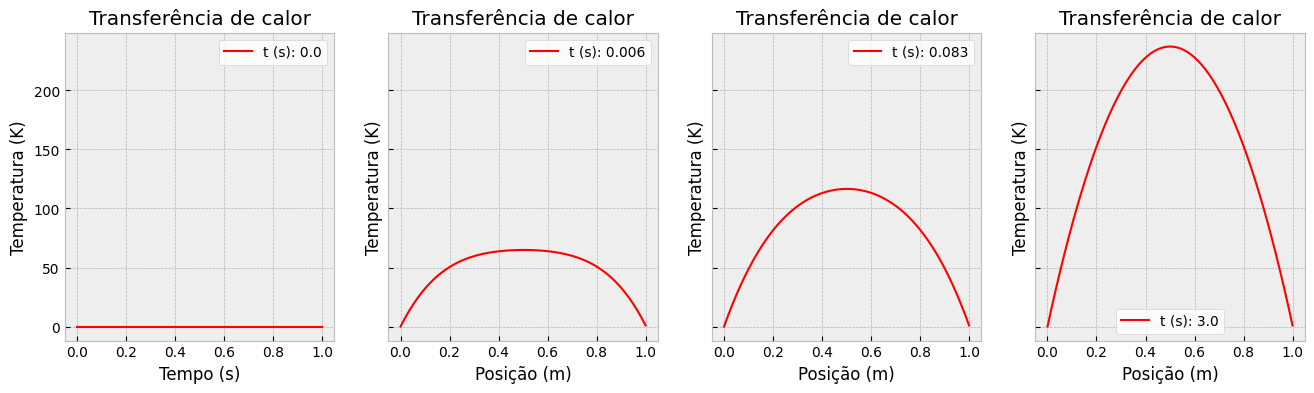

In [43]:
def dif_explicita_dirichlet(alpha, Q, Tto, To, Tf, xo, xf, to, tf, pontosX, pontost):
  DomX, hx = Dom_h(xo, xf, pontosX)
  Domt, ht = Dom_h(to, tf, pontost)
  Sol_T = np.empty((Domt.shape[0],DomX.shape[0]))
  print(Sol_T.shape)

  if ht < hx**2/(2*alpha):
    #Temperaturas em cada ponto no instante t = 0 (1ª C.C.)
    t0 = np.ones(DomX.shape)
    t0 = t0*Tto
    Sol_T[0] = t0 

    for t in range(1,len(Domt)):
    
      #1º ponto da barra (2ª C.C.)
      Sol_T[t,0] = To 

      for x in range(1,len(DomX)-1):
      
        T = (alpha*ht/hx**2)*Sol_T[t-1,x-1] + (1 - 2*alpha*ht/hx**2)*Sol_T[t-1,x] + (alpha*ht/hx**2)*Sol_T[t-1,x+1] + ht*Q
        Sol_T[t,x] = T

      #Último ponto da barra (2ª C.C.)
      Sol_T[t,-1] = Tf

    return DomX, Domt, Sol_T

  else:
      print("Solução não converge para os parâmetros dados.")


#PLOTAGEM################################################

#Parâmetros: alpha, Q, Tto, To, Tf, xo, xf, to, tf, pontosX, pontost

alpha = 0.1
Q = 200
Tto = 0
To = 0
Tf = 1
xo = 0
xf = 1
to = 0
tf = 3
pontosX = 60
pontost = 10800

DomX, Domt, Sol_T = dif_explicita_dirichlet(alpha, Q, Tto, To, Tf, xo, xf, to, tf, pontosX, pontost)    #para referenciar funções nos argumentos de outra função, basta escrever seu nome sem parênteses

plt.style.use('bmh')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, sharex = True, figsize = (16,4))
    
ax1.plot(DomX, Sol_T[0,:], color='red', linewidth=1.5, label=r't (s): {}'.format(np.around(Domt[0],3)))
ax1.set_title('Transferência de calor')
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Temperatura (K)')
ax1.legend(loc='best',facecolor ='w')

ax2.plot(DomX, Sol_T[1200,:], color='red', linewidth=1.5, label=r't (s): {}'.format(np.around(Domt[20],3)))
ax2.set_title('Transferência de calor')
ax2.set_xlabel('Posição (m)')
ax2.set_ylabel('Temperatura (K)')
ax2.legend(loc='best',facecolor ='w')

ax3.plot(DomX, Sol_T[2400,:], color='red', linewidth=1.5, label=r't (s): {}'.format(np.around(Domt[300],3)))
ax3.set_title('Transferência de calor')
ax3.set_xlabel('Posição (m)')
ax3.set_ylabel('Temperatura (K)')
ax3.legend(loc='best',facecolor ='w')

ax4.plot(DomX, Sol_T[-1,:], color='red', linewidth=1.5, label=r't (s): {}'.format(np.around(Domt[-1],3)))
ax4.set_title('Transferência de calor')
ax4.set_xlabel('Posição (m)')
ax4.set_ylabel('Temperatura (K)')
ax4.legend(loc='best',facecolor ='w')

Problema de transferência de calor transiente

$\frac{1}{\alpha}\frac{\partial T(x,t)}{\partial t} = \frac{\partial^2 T(x,t)}{\partial x^2} - m^2(T - T_{\infty})$

$T(x=0,t) = T_b$

$T(x,t=0) = T_{\infty}$

$k\frac{\partial T(x,t)}{\partial x} + h(T - T_{\infty}) = 0$

(3600, 60)


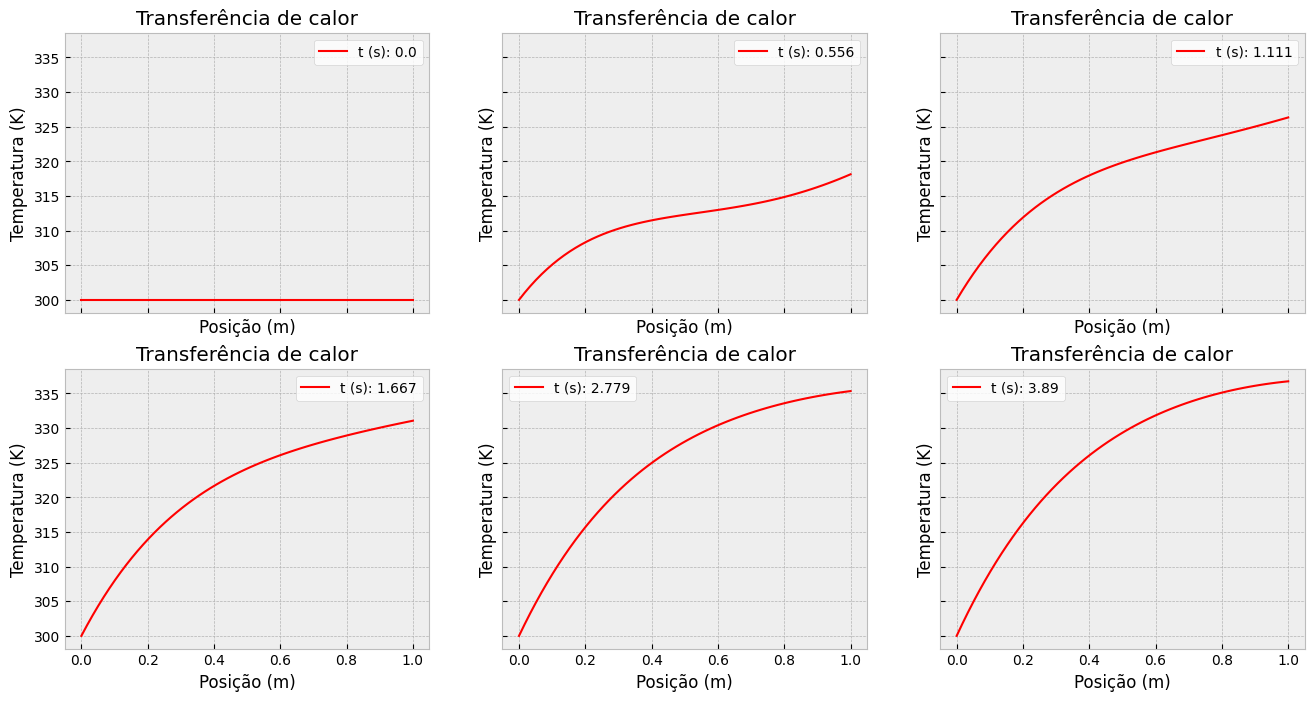

In [42]:
def dif_explicita_neumann(alpha, m, Tb, Tinf, k, h, xo, xf, to, tf, pontosX, pontost):

  DomX, hx = Dom_h(xo, xf, pontosX)
  Domt, ht = Dom_h(to, tf, pontost)
  Sol_T = np.empty((Domt.shape[0],DomX.shape[0]))
  print(Sol_T.shape)

  if ht < 1/((2*alpha)/hx**2 +alpha*m**2):
    #Temperaturas em cada ponto no instante t = 0 (1ª C.C.)
    t0 = np.ones(DomX.shape)
    t0 = t0*Tb
    Sol_T[0] = t0 

    for t in range(1,len(Domt)):
    
      #1º ponto da barra (2ª C.C.)
      T0 = Tb
      Sol_T[t,0] = T0 

      for x in range(1,len(DomX)-1):
      
        T = (alpha*ht/hx**2)*Sol_T[t-1,x-1] + (1 - 2*alpha*ht/hx**2 - alpha*ht*m**2)*Sol_T[t-1,x] + (alpha*ht/hx**2)*Sol_T[t-1,x+1] + alpha*ht*m**2*Tinf
        Sol_T[t,x] = T

      #Último ponto da barra depende de nó fictício (3ª C.C.)
      xfic = Sol_T[t-1, -2] - (2*hx*h/k)*Sol_T[t-1,-1] + (2*hx*h/k)*Tinf
      Tf = (alpha*ht/hx**2)*Sol_T[t-1,x-1] + (1 - 2*alpha*ht/hx**2 - alpha*ht*m**2)*Sol_T[t-1,x] + (alpha*ht/hx**2)*xfic + alpha*ht*m**2*Tinf
      Sol_T[t,-1] = Tf

    return DomX, Domt, Sol_T

  else:
      print("Solução não converge para os parâmetros dados.")

#PLOTAGEM################################################

#Parâmetros: alpha, m, Tb, Tinf, k, h, xo, xf, to, tf, pontosX, pontost

alpha = 0.1
m = 2.466
Tb = 300
Tinf = 343
k = 80
h = 100
xo = 0
xf = 1
to = 0
tf = 5
pontosX = 60
pontost = 3600

DomX, Domt, Sol_T = dif_explicita_neumann(alpha, m, Tb, Tinf, k, h, xo, xf, to, tf, pontosX, pontost)    #para referenciar funções nos argumentos de outra função, basta escrever seu nome sem parênteses

plt.style.use('bmh')

fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, sharey=True, sharex = True, figsize = (16,8))
    
ax1.plot(DomX, Sol_T[0,:], color='red', linewidth=1.5, label=r't (s): {}'.format(np.around(Domt[0],3)))
ax1.set_title('Transferência de calor')
ax1.set_xlabel('Posição (m)')
ax1.set_ylabel('Temperatura (K)')
ax1.legend(loc='best',facecolor ='w')

ax2.plot(DomX, Sol_T[400,:], color='red', linewidth=1.5, label=r't (s): {}'.format(np.around(Domt[400],3)))
ax2.set_title('Transferência de calor')
ax2.set_xlabel('Posição (m)')
ax2.set_ylabel('Temperatura (K)')
ax2.legend(loc='best',facecolor ='w')

ax3.plot(DomX, Sol_T[800,:], color='red', linewidth=1.5, label=r't (s): {}'.format(np.around(Domt[800],3)))
ax3.set_title('Transferência de calor')
ax3.set_xlabel('Posição (m)')
ax3.set_ylabel('Temperatura (K)')
ax3.legend(loc='best',facecolor ='w')

ax4.plot(DomX, Sol_T[1200,:], color='red', linewidth=1.5, label=r't (s): {}'.format(np.around(Domt[1200],3)))
ax4.set_title('Transferência de calor')
ax4.set_xlabel('Posição (m)')
ax4.set_ylabel('Temperatura (K)')
ax4.legend(loc='best',facecolor ='w')

ax5.plot(DomX, Sol_T[2000,:], color='red', linewidth=1.5, label=r't (s): {}'.format(np.around(Domt[2000],3)))
ax5.set_title('Transferência de calor')
ax5.set_xlabel('Posição (m)')
ax5.set_ylabel('Temperatura (K)')
ax5.legend(loc='best',facecolor ='w')

ax6.plot(DomX, Sol_T[2800,:], color='red', linewidth=1.5, label=r't (s): {}'.format(np.around(Domt[2800],3)))
ax6.set_title('Transferência de calor')
ax6.set_xlabel('Posição (m)')
ax6.set_ylabel('Temperatura (K)')
ax6.legend(loc='best',facecolor ='w')

#### Problema de transferência de calor transiente (método implícito):

*   Derivada centrada para o espaço e **atrasada** para o tempo
*   Sistema linear
*   Estável

Para cada instante N, haverá um sistema linear para se obter os valores de T em cada nó i do domínio X.


$\frac{\partial T}{\partial t} = \alpha\frac{\partial^2 T}{\partial x^2} + Q \;\; , \;\; \alpha = 0.1 \frac{kJm^2}{K} \;\; , \;\; Q = 0.2 kJ$

$T(x,t=0) = 0$

$T(x=0,t) = 0$

$f(x=L,t) = 1$

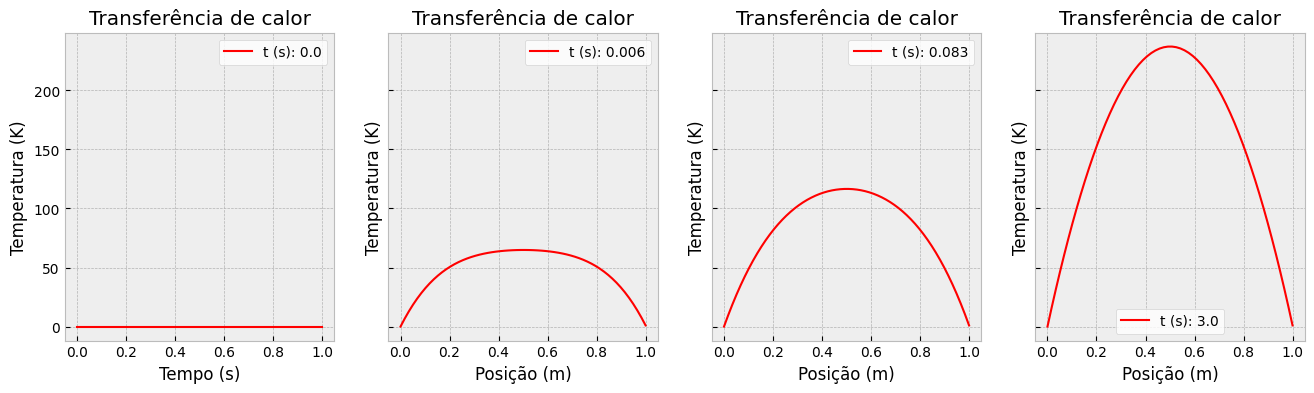

In [47]:
def dif_implicita_dirichlet(alpha, Q, Tto, To, Tf, xo, xf, to, tf, pontosX, pontost):
  DomX, hx = Dom_h(xo, xf, pontosX)
  Domt, ht = Dom_h(to, tf, pontost)
  Sol_T = np.empty((Domt.shape[0],DomX.shape[0]))

  ###Temperaturas em cada ponto no instante t = 0 (1ª C.C.)
  t0 = np.ones(DomX.shape)
  t0 = t0*Tto
  Sol_T[0] = t0 

  ###Já temos a 1ª linha como C.C., faremos agora a 2ª manualmente e em seguida as demais por recorrência

  ##Vetor de termos independentes para N = 1:
  
  #I = Sol_T[0,1:-1]   !!!ATENÇÃO: Definindo I desta forma, quando mudarmos uma propriedade em I também estaremos mudando em Sol_T!!!
  I = np.empty(Sol_T[0,1:-1].shape)
  
  #É necessário adicionar os valores de contorno conhecidos ao vetor B:
  a_index = 0
  b_index = -1

  I[a_index] = ((alpha*ht)/(hx**2))*To + Tto + ht*Q
  I[b_index] = ((alpha*ht)/(hx**2))*Tf + Tto + ht*Q

  for indice in range(1,len(DomX) - 3):
  
    I[indice] = Tto + ht*Q   #adicionando os valores de r(x) em B

  ##Matriz de coeficientes
  M = np.zeros([DomX.size - 2,DomX.size -2])

  #Inserindo a primeira e última linhas manualmente:
  M[0,0] = (1 + (2*alpha*ht)/(hx**2))      #primeira linha 
  M[0,1] = -(alpha*ht)/(hx**2)

  M[-1,-2] = -(alpha*ht)/(hx**2)          #última linha
  M[-1,-1] = (1 + (2*alpha*ht)/(hx**2))

  #Inserindo as restantes:
  for linha in range(1,len(DomX) - 3):
    M[linha,linha-1] = -(alpha*ht)/(hx**2)
    M[linha,linha] = (1 + (2*alpha*ht)/(hx**2))
    M[linha,linha+1] = -(alpha*ht)/(hx**2)

  ##Valores de T ao longo de X para o instante N
  T = np.linalg.solve(M,I)
  
  So = np.array([To])
  Sf = np.array([Tf])
  T = np.concatenate((So,T,Sf))

  Sol_T[1] = T

  ###Fizemos a 2ª linha de temperaturas a partir da 1ª, agora faremos as restantes
  for t in range(2,len(Domt)):
    I = np.empty(T.shape[0] - 2)

  #É necessário adicionar os valores de contorno conhecidos ao vetor B:
    I[0] = ((alpha*ht)/hx**2)*To + T[1] + ht*Q
    I[-1] = ((alpha*ht)/hx**2)*Tf + T[-2] + ht*Q
  
    for indice in range(1,T.shape[0] - 3):
  
      I[indice] = T[indice+1] + ht*Q 

    T = np.linalg.solve(M,I)

    So = np.array([To])
    Sf = np.array([Tf])
    T = np.concatenate((So,T,Sf))

    Sol_T[t] = T

  return DomX, Domt, Sol_T

#PLOTAGEM################################################

#Parâmetros: alpha, Q, Tto, To, Tf, xo, xf, to, tf, pontosX, pontost

alpha = 0.1
Q = 200
Tto = 0
Tf = 1
xo = 0
xf = 1
to = 0
tf = 3
pontosX = 60
pontost = 10800

DomX, Domt, Sol_T = dif_implicita_dirichlet(alpha, Q, Tto, To, Tf, xo, xf, to, tf, pontosX, pontost)    #para referenciar funções nos argumentos de outra função, basta escrever seu nome sem parênteses

plt.style.use('bmh')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, sharex = True, figsize = (16,4))
    
ax1.plot(DomX, Sol_T[0,:], color='red', linewidth=1.5, label=r't (s): {}'.format(np.around(Domt[0],3)))
ax1.set_title('Transferência de calor')
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Temperatura (K)')
ax1.legend(loc='best',facecolor ='w')

ax2.plot(DomX, Sol_T[1200,:], color='red', linewidth=1.5, label=r't (s): {}'.format(np.around(Domt[20],3)))
ax2.set_title('Transferência de calor')
ax2.set_xlabel('Posição (m)')
ax2.set_ylabel('Temperatura (K)')
ax2.legend(loc='best',facecolor ='w')

ax3.plot(DomX, Sol_T[2400,:], color='red', linewidth=1.5, label=r't (s): {}'.format(np.around(Domt[300],3)))
ax3.set_title('Transferência de calor')
ax3.set_xlabel('Posição (m)')
ax3.set_ylabel('Temperatura (K)')
ax3.legend(loc='best',facecolor ='w')

ax4.plot(DomX, Sol_T[-1,:], color='red', linewidth=1.5, label=r't (s): {}'.format(np.around(Domt[-1],3)))
ax4.set_title('Transferência de calor')
ax4.set_xlabel('Posição (m)')
ax4.set_ylabel('Temperatura (K)')
ax4.legend(loc='best',facecolor ='w')

#### Solução da equação de onda (método implícito): INACABADO

Solução da Equação de Onda:

$\frac{\partial^2 f(x,t)}{\partial t^2} = c^2\frac{\partial^2 f(x,t)}{\partial x^2}$

$f(x,t=0) = x$

$\frac{\partial f(x,t=0)}{\partial t} = 0$

$f(x=0,t) = 0$

$\frac{\partial f(x=L,t)}{\partial x} = 0$

In [ ]:
def dif_implicita_onda(c, To, Tf, xo, xf, to, tf, pontosX, pontost):
  DomX, hx = Dom_h(xo, xf, pontosX)
  Domt, ht = Dom_h(to, tf, pontost)
  Sol_T = np.empty((Domt.shape[0],DomX.shape[0]))

  ###Temperaturas em cada ponto no instante t = 0 (1ª C.C.)
  #Tto = DomX
  Tto = np.zeros(DomX.shape)
  #Tto = np.sin(DomX)
  Sol_T[0] = Tto

  ###Já temos a 1ª linha como C.C., faremos agora a 2ª manualmente e em seguida as demais por recorrência

  ##Vetor de termos independentes para N = 1:
  
  #I = Sol_T[0,1:-1]   !!!ATENÇÃO: Definindo I desta forma, quando mudarmos uma propriedade em I também estaremos mudando em Sol_T!!!
  I = np.empty(Sol_T[0,1:-1].shape)
  
  #É necessário adicionar os valores de contorno conhecidos ao vetor B:
  
  I[0] = 2*Sol_T[0,1] - Sol_T[0,1] + ((c*ht)/hx)**2*To
  
  '''
  I[0] = 2*Sol_T[0,1] - (-ht*np.sin(DomX[1]) + Sol_T[0,1]) + ((c*ht)/hx)**2*To
  I[-1] = 2*Sol_T[0,-2] - (-ht*np.sin(DomX[-2]) + Sol_T[0,-2]) + ((c*ht)/hx)**2*Tf
  '''
  for indice in range(1,len(DomX) - 3):
  
    I[indice] = 2*Sol_T[0,indice+1] - Sol_T[0,indice+1]   #adicionando os valores de r(x) em B

  I[-1] = 2*Sol_T[0,-2] - Sol_T[0,-2] + ((c*ht)/hx)**2*Tf

  ##Matriz de coeficientes
  M = np.zeros([DomX.size - 2,DomX.size -2])

  #Inserindo a primeira e última linhas manualmente:
  M[0,0] = (1 + 2*((c*ht)/hx)**2)      #primeira linha 
  M[0,1] = -((c*ht)/hx)**2

  M[-1,-2] = -((c*ht)/hx)**2         #última linha
  M[-1,-1] = (1 + 2*((c*ht)/hx)**2)

  #Inserindo as restantes:
  for linha in range(1,len(DomX) - 3):
    M[linha,linha-1] = -((c*ht)/hx)**2
    M[linha,linha] = (1 + 2*((c*ht)/hx)**2)
    M[linha,linha+1] = -((c*ht)/hx)**2

  ##Valores de T ao longo de X para o instante N
  T = np.linalg.solve(M,I)
  
  So = np.array([To])
  Sf = np.array([Tf])
  T = np.concatenate((So,T,Sf))

  Sol_T[1] = T

  ###Fizemos a 2ª linha de temperaturas a partir da 1ª, agora faremos as restantes
  for t in range(2,len(Domt)):
    I = np.empty(T.shape[0] - 2)

  #É necessário adicionar os valores de contorno conhecidos ao vetor B:
    
    I[0] = 2*Sol_T[t-1,1] - Sol_T[t-2,1] + ((c*ht)/hx)**2*To
    
    '''
    I[0] = 2*Sol_T[t-1,1] - (-ht*np.sin(DomX[1]) + Sol_T[t-2,1]) + ((c*ht)/hx)**2*To
    I[-1] = 2*Sol_T[t-1,-2] - (-ht*np.sin(DomX[-2]) + Sol_T[t-2,-2]) + ((c*ht)/hx)**2*Tf  
    '''
    for indice in range(1,T.shape[0] - 3):
  
      I[indice] = 2*Sol_T[t-1,indice+1] - Sol_T[t-2,indice+1]

    I[-1] = 2*Sol_T[t-1,-2] - Sol_T[t-2,-2] + ((c*ht)/hx)**2*Tf

    T = np.linalg.solve(M,I)

    So = np.array([To])
    Sf = np.array([Tf])
    T = np.concatenate((So,T,Sf))

    Sol_T[t] = T

  return DomX, Domt, Sol_T

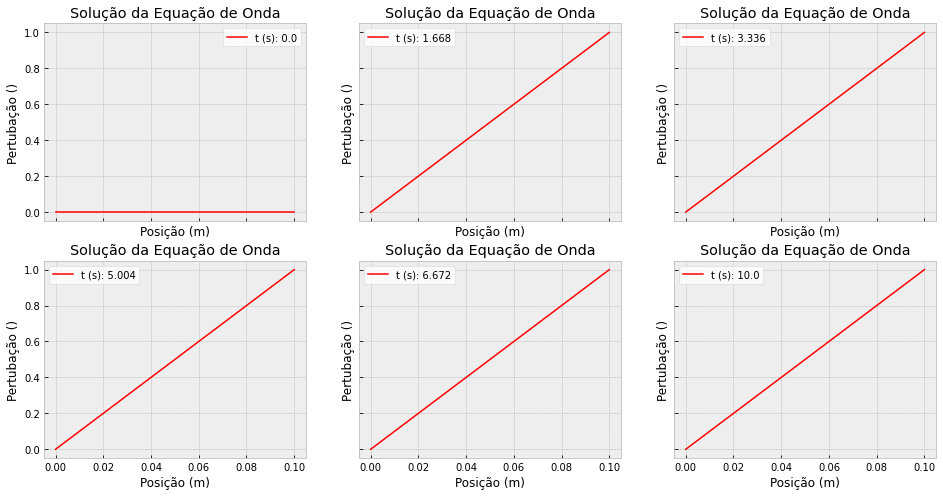

In [ ]:
#Parâmetros: c, To, Tf, xo, xf, to, tf, pontosX, pontost

c = 10
To = 0
Tf = 1
xo = 0
xf = 0.1
to = 0
tf = 10
pontosX = 300
pontost = 1200

DomX, Domt, Sol_T = dif_implicita_onda(c, To, Tf, xo, xf, to, tf, pontosX, pontost)    #para referenciar funções nos argumentos de outra função, basta escrever seu nome sem parênteses

plt.style.use('bmh')
'''
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, sharex = True, figsize = (16,4))
    
ax1.plot(DomX, Sol_T[0,:], color='red', linewidth=1.5, label=r't (s): {}'.format(np.around(Domt[0],3)))
ax1.set_title('Solução da Equação de Onda')
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Pertubação ()')
ax1.legend(loc='best',facecolor ='w')

ax2.plot(DomX, Sol_T[400,:], color='red', linewidth=1.5, label=r't (s): {}'.format(np.around(Domt[400],3)))
ax2.set_title('Solução da Equação de Onda')
ax2.set_xlabel('Tempo (s)')
ax2.set_ylabel('Pertubação ()')
ax2.legend(loc='best',facecolor ='w')

ax3.plot(DomX, Sol_T[800,:], color='red', linewidth=1.5, label=r't (s): {}'.format(np.around(Domt[800],3)))
ax3.set_title('Solução da Equação de Onda')
ax3.set_xlabel('Tempo (s)')
ax3.set_ylabel('Pertubação ()')
ax3.legend(loc='best',facecolor ='w')

ax4.plot(DomX, Sol_T[-1,:], color='red', linewidth=1.5, label=r't (s): {}'.format(np.around(Domt[-1],3)))
ax4.set_title('Solução da Equação de Onda')
ax4.set_xlabel('Tempo (s)')
ax4.set_ylabel('Pertubação ()')
ax4.legend(loc='best',facecolor ='w')
'''

fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, sharey=True, sharex = True, figsize = (16,8))
    
ax1.plot(DomX, Sol_T[0,:], color='red', linewidth=1.5, label=r't (s): {}'.format(np.around(Domt[0],3)))
ax1.set_title('Solução da Equação de Onda')
ax1.set_xlabel('Posição (m)')
ax1.set_ylabel('Pertubação ()')
ax1.legend(loc='best',facecolor ='w')

ax2.plot(DomX, Sol_T[200,:], color='red', linewidth=1.5, label=r't (s): {}'.format(np.around(Domt[200],3)))
ax2.set_title('Solução da Equação de Onda')
ax2.set_xlabel('Posição (m)')
ax2.set_ylabel('Pertubação ()')
ax2.legend(loc='best',facecolor ='w')

ax3.plot(DomX, Sol_T[400,:], color='red', linewidth=1.5, label=r't (s): {}'.format(np.around(Domt[400],3)))
ax3.set_title('Solução da Equação de Onda')
ax3.set_xlabel('Posição (m)')
ax3.set_ylabel('Pertubação ()')
ax3.legend(loc='best',facecolor ='w')

ax4.plot(DomX, Sol_T[600,:], color='red', linewidth=1.5, label=r't (s): {}'.format(np.around(Domt[600],3)))
ax4.set_title('Solução da Equação de Onda')
ax4.set_xlabel('Posição (m)')
ax4.set_ylabel('Pertubação ()')
ax4.legend(loc='best',facecolor ='w')

ax5.plot(DomX, Sol_T[800,:], color='red', linewidth=1.5, label=r't (s): {}'.format(np.around(Domt[800],3)))
ax5.set_title('Solução da Equação de Onda')
ax5.set_xlabel('Posição (m)')
ax5.set_ylabel('Pertubação ()')
ax5.legend(loc='best',facecolor ='w')

ax6.plot(DomX, Sol_T[1199,:], color='red', linewidth=1.5, label=r't (s): {}'.format(np.around(Domt[1199],3)))
ax6.set_title('Solução da Equação de Onda')
ax6.set_xlabel('Posição (m)')
ax6.set_ylabel('Pertubação ()')
ax6.legend(loc='best',facecolor ='w')

(300,)


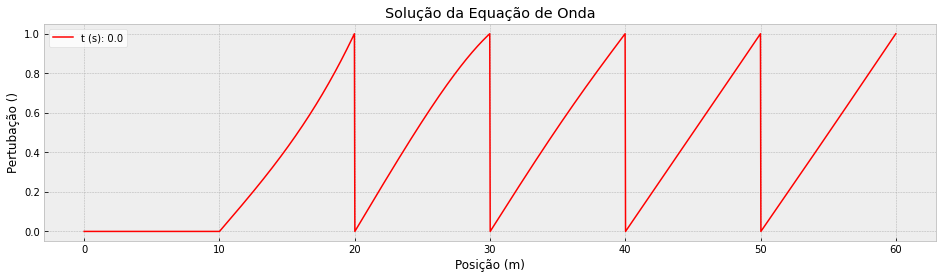

In [ ]:
DomX, Domt, Sol_T = dif_implicita_onda(c, To, Tf, xo, xf, to, tf, pontosX, pontost)    #para referenciar funções nos argumentos de outra função, basta escrever seu nome sem parênteses

plt.style.use('bmh')

fig, ax1 = plt.subplots(sharey=True, sharex = True, figsize = (16,4))

T1 = np.array(Sol_T[0,:])
T2 = np.array(Sol_T[1,:])
T3 = np.array(Sol_T[2,:])
T4 = np.array(Sol_T[3,:])
T5 = np.array(Sol_T[4,:])
T6 = np.array(Sol_T[5,:])
print(T1.shape)
T = np.concatenate((T1,T2,T3,T4,T5,T6))

DomX, hx = Dom_h(0, 60, 1800)

ax1.plot(DomX, T, color='red', linewidth=1.5, label=r't (s): {}'.format(np.around(Domt[0],3)))
ax1.set_title('Solução da Equação de Onda')
ax1.set_xlabel('Posição (m)')
ax1.set_ylabel('Pertubação ()')
ax1.legend(loc='best',facecolor ='w')

#### Problemas bidimensionais

Condução de calor transiente numa placa de aço

$\frac{1}{\alpha}\frac{\partial T(x,y,t)}{\partial t} = \nabla^2 T(x,y,t) + \frac{G}{K} \;\; , \;\; \alpha = 8 \cdot 10^{-4} \frac{m^2}{s} \;\; , \;\; G = 0 \frac{J}{m^3} \;\; , \;\;\ K = 34 \frac{W}{m.K}$

$T(x,y,t=0) = 300$

$T(x=0,y,t) = 300 \;, \;\; \frac{\partial T(x=L_x,y,t)}{\partial x} = 0$

$T(x,y=0,t) = 300 \;, \;\; \frac{\partial T(x,y=L_y,t)}{\partial y} = 0 $

##### Solução numérica: Método implícito

In [20]:
def dif_implicitaXY(alpha, Q, Tto, Tox, Toy, xo, xf, yo, yf, to, tf, pontosX, pontosY, pontost):   #Onde Q = G/K
  DomX, hx = Dom_h(xo, xf, pontosX)
  DomY, hy = Dom_h(yo, yf, pontosY)
  Domt, ht = Dom_h(to, tf, pontost)
  Sol_T = np.empty((DomX.shape[0],DomY.shape[0],Domt.shape[0]))

  ###Temperaturas em cada ponto no instante t = 0 (1ª C.C.)
  ###Temperaturas e fluxo prescritos nas extremidades de X (2ª e 3ª C.C.)
  ###Temperatura e fluxo prescritos nas extremidades de Y (4ª e 5ª C.C.)

  Sol_T = np.empty((len(DomX),len(DomY),len(Domt)))

  XYto = np.ones((len(DomX),len(DomY)))
  XYto = XYto*Tto
  CCox = np.ones(len(DomX))
  CCox = CCox*Tox
  CCoy = np.ones(len(DomY))
  CCoy = CCoy*Toy

  #T0
  Sol_T[:,:,0] = XYto
  Sol_T[:,0,0] = CCox
  Sol_T[0,:,0] = CCoy

  NP = (len(DomX)-1)*(len(DomY)-1)
  M = np.zeros([NP,NP])
  I = np.empty(NP)

  #Armazenamos os resultados em duas dimensões (X e Y), mas montamos o sistema linear pela contagem de nós,
  #então para referenciar os nós passados na recorrência a seguir, é preciso guardar os resultados nessa forma de contagem por nós.

  temporal = np.empty((len(Domt),NP))    #Matriz que armazena vetores de parcelas temporais do vetor de termos independentes
  
  parcela_temporal_inicial = np.ones(NP)
  parcela_temporal_inicial = parcela_temporal_inicial*Tto

  temporal[0] = parcela_temporal_inicial

  for n in range(1,len(Domt)):
    for i in range(NP):
      if i%(len(DomX)-1) == 0 and i <= (len(DomX)-1):   #vértice esquerda inferior
        I[i] = (alpha*ht/hx**2)*Tox + (alpha*ht/hy**2)*Toy + temporal[n-1,i] + ht*alpha*Q
        
        M[i,i] = (1+2*(alpha*ht/hx**2)+2*(alpha*ht/hy**2))
        M[i,i+1] = -(alpha*ht/hx**2)
        M[i,i+(len(DomX)-1)] = -(alpha*ht/hy**2)

      elif i%(len(DomX)-1) == 0 and (len(DomX)-1) < i < (NP - (len(DomX)-1)):   #aresta esquerda
        I[i] = (alpha*ht/hx**2)*Tox + temporal[n-1,i] + ht*alpha*Q
        
        M[i,i-(len(DomX)-1)] = -(alpha*ht/hy**2)
        M[i,i] = (1+2*(alpha*ht/hx**2)+2*(alpha*ht/hy**2))
        M[i,i+1] = -(alpha*ht/hx**2)
        M[i,i+(len(DomX)-1)] = -(alpha*ht/hy**2)

      elif i%(len(DomX)-1) == 0 and i >= (NP - (len(DomX)-1)):   #vértice esquerda superior
        I[i] = (alpha*ht/hx**2)*Tox + temporal[n-1,i] + ht*alpha*Q

        M[i,i-(len(DomX)-1)] = -2*(alpha*ht/hy**2)
        M[i,i] = (1+2*(alpha*ht/hx**2)+2*(alpha*ht/hy**2))
        M[i,i+1] = -(alpha*ht/hx**2)

      elif i%(len(DomX)-1) == len(DomX)-2 and i <= (len(DomX)-1):   #vértice direita inferior
        I[i] = (alpha*ht/hy**2)*Toy + temporal[n-1,i] + ht*alpha*Q

        M[i,i-1] = -2*(alpha*ht/hx**2)
        M[i,i] = (1+2*(alpha*ht/hx**2)+2*(alpha*ht/hy**2))
        M[i,i+(len(DomX)-1)] = -(alpha*ht/hy**2)

      elif i%(len(DomX)-1) == len(DomX)-2 and (len(DomX)-1) < i < (NP - (len(DomX)-1)):   #aresta direita
        I[i] = temporal[n-1,i] + ht*alpha*Q

        M[i,i-(len(DomX)-1)] = -(alpha*ht/hy**2)
        M[i,i-1] = -2*(alpha*ht/hx**2)
        M[i,i] = (1+2*(alpha*ht/hx**2)+2*(alpha*ht/hy**2))
        M[i,i+(len(DomX)-1)] = -(alpha*ht/hy**2)

      elif i%(len(DomX)-1) == len(DomX)-2 and i >= (NP - (len(DomX)-1)):   #vértice direita superior
        I[i] = temporal[n-1,i] + ht*alpha*Q

        M[i,i-(len(DomX)-1)] = -2*(alpha*ht/hy**2)
        M[i,i-1] = -2*(alpha*ht/hx**2)
        M[i,i] = (1+2*(alpha*ht/hx**2)+2*(alpha*ht/hy**2))

      elif i <= (len(DomX)-1) and i%(len(DomX)-1) != 0 and i%(len(DomX)-1) != len(DomX)-2:   #aresta inferior
        I[i] = (alpha*ht/hy**2)*Toy + temporal[n-1,i] + ht*alpha*Q
      
        M[i,i-1] = -(alpha*ht/hx**2)
        M[i,i] = (1+2*(alpha*ht/hx**2)+2*(alpha*ht/hy**2))
        M[i,i+1] = -(alpha*ht/hx**2)
        M[i,i+(len(DomX)-1)] = -(alpha*ht/hy**2)

      elif i >= (NP - (len(DomX)-1)) and i%(len(DomX)-1) != 0 and i%(len(DomX)-1) != len(DomX)-2:   #aresta superior
        I[i] = temporal[n-1,i] + ht*alpha*Q

        M[i,i-(len(DomX)-1)] = -2*(alpha*ht/hy**2)
        M[i,i-1] = -(alpha*ht/hx**2)
        M[i,i] = (1+2*(alpha*ht/hx**2)+2*(alpha*ht/hy**2))
        M[i,i+1] = -(alpha*ht/hx**2)

      else:
        I[i] = temporal[n-1,i] + ht*alpha*Q

        M[i,i-(len(DomX)-1)] = -(alpha*ht/hy**2)
        M[i,i-1] = -(alpha*ht/hx**2)
        M[i,i] = (1+2*(alpha*ht/hx**2)+2*(alpha*ht/hy**2))
        M[i,i+1] = -(alpha*ht/hx**2)
        M[i,i+(len(DomX)-1)] = -(alpha*ht/hy**2)

  ##Valores de T ao longo de X e Y para o instante N

    T = np.linalg.solve(M,I)

    temporal[n] = T

    XY = np.reshape(T,[len(DomX)-1,len(DomY)-1])

    CCox = np.ones(len(DomX)-1)
    CCox = CCox*Tox
    CCoy = np.ones(len(DomY))
    CCoy = CCoy*Toy

    #Manipulação de matriz de resultados para inserção das linhas iniciais de X e Y
    #O método np.insert adiciona a linha desejada onde é requerido mas reduz a matriz a uma dimensão logo em seguida, por isso é necessário usar o método reshape após insert

    XY = np.insert(XY,0,CCox)
    XY = np.reshape(XY,[len(DomX),len(DomY)-1])

    XYt = np.transpose(XY)
    XYt = np.insert(XYt,0,CCoy)
    XY = np.reshape(XYt,[len(DomY),len(DomX)])

    XY = np.transpose(XY)

    Sol_T[:,:,n] = XY
  
  return DomX, DomY, Domt, Sol_T


In [44]:
#Parâmetros: alpha, Q, Tto, Tox, Toy, xo, xf, yo, yf, to, tf, pontosX, pontosY, pontost    #Onde Q = G/K

#DomX, DomY, Domt, Sol_T = dif_implicitaXY(0.0008, 20*10**3/34, 300, 300, 300, 0, 1, 0, 1, 0, 360, 40, 40, 5)
DomX, DomY, Domt, Sol_T = dif_implicitaXY(0.0008, 0, 50, 300, 300, 0, 1, 0, 1, 0, 480, 40, 40, 6)

Plotagem

C:\Users\jferreira\AppData\Local\Temp\ipykernel_23192\637474907.py:67: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(surf4, shrink=0.5, aspect=5)


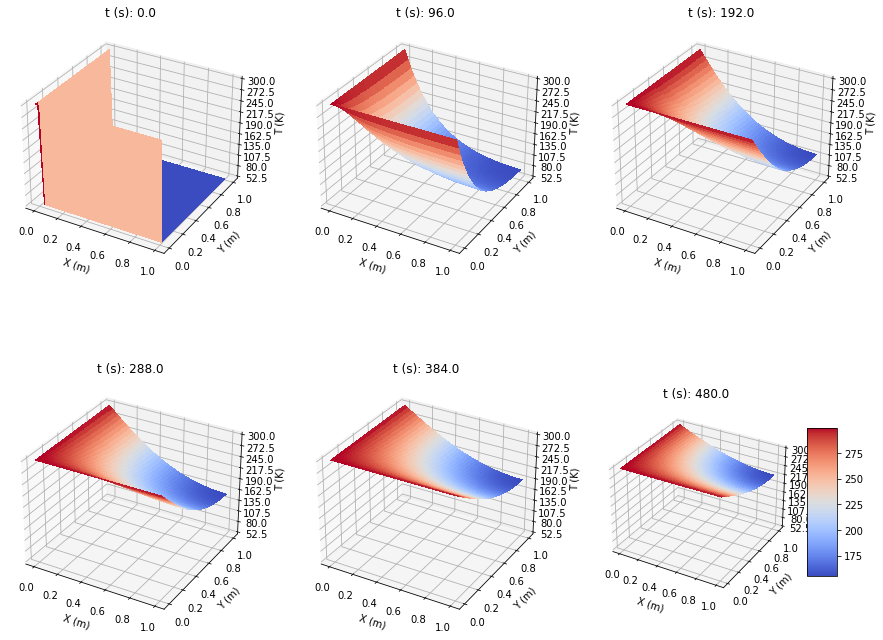

In [45]:

X, Y = np.meshgrid(DomX, DomY)

# Plot the surface.

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = (15,12), subplot_kw={"projection": "3d"})

surf1 = ax1.plot_surface(X, Y, Sol_T[:,:,0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
surf2 = ax2.plot_surface(X, Y, Sol_T[:,:,1], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
surf3 = ax3.plot_surface(X, Y, Sol_T[:,:,2], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
surf4 = ax4.plot_surface(X, Y, Sol_T[:,:,3], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
surf5 = ax5.plot_surface(X, Y, Sol_T[:,:,4], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
surf6 = ax6.plot_surface(X, Y, Sol_T[:,:,5], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customizing graphics

ax1.set_title('t (s): {}'.format(np.around(Domt[0],2)))
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_zlabel('T (K)')

ax2.set_title('t (s): {}'.format(np.around(Domt[1],2)))
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.set_zlabel('T (K)')

ax3.set_title('t (s): {}'.format(np.around(Domt[2],2)))
ax3.set_xlabel('X (m)')
ax3.set_ylabel('Y (m)')
ax3.set_zlabel('T (K)')

ax4.set_title('t (s): {}'.format(np.around(Domt[3],2)))
ax4.set_xlabel('X (m)')
ax4.set_ylabel('Y (m)')
ax4.set_zlabel('T (K)')

ax5.set_title('t (s): {}'.format(np.around(Domt[4],2)))
ax5.set_xlabel('X (m)')
ax5.set_ylabel('Y (m)')
ax5.set_zlabel('T (K)')

ax6.set_title('t (s): {}'.format(np.around(Domt[5],2)))
ax6.set_xlabel('X (m)')
ax6.set_ylabel('Y (m)')
ax6.set_zlabel('T (K)')

# Customizing the z axis.
ax1.zaxis.set_major_locator(LinearLocator(10))
ax1.set_zlim(Sol_T[-1,-1,0] + 0.05*Sol_T[-1,-1,0], 300)
ax2.zaxis.set_major_locator(LinearLocator(10))
ax2.set_zlim(Sol_T[-1,-1,0] + 0.05*Sol_T[-1,-1,0], 300)
ax3.zaxis.set_major_locator(LinearLocator(10))
ax3.set_zlim(Sol_T[-1,-1,0] + 0.05*Sol_T[-1,-1,0], 300)
ax4.zaxis.set_major_locator(LinearLocator(10))
ax4.set_zlim(Sol_T[-1,-1,0] + 0.05*Sol_T[-1,-1,0], 300)
ax5.zaxis.set_major_locator(LinearLocator(10))
ax5.set_zlim(Sol_T[-1,-1,0] + 0.05*Sol_T[-1,-1,0], 300)
ax6.zaxis.set_major_locator(LinearLocator(10))
ax6.set_zlim(Sol_T[-1,-1,0] + 0.05*Sol_T[-1,-1,0], 300)

# Add a color bar which maps values to colors.
fig.colorbar(surf4, shrink=0.5, aspect=5)

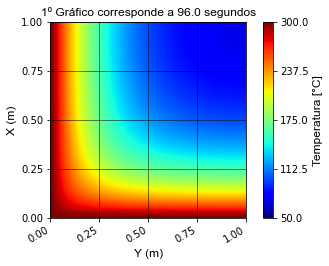

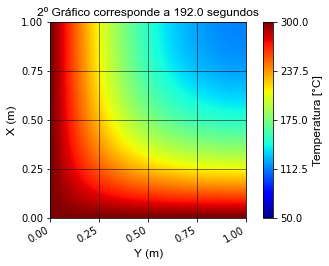

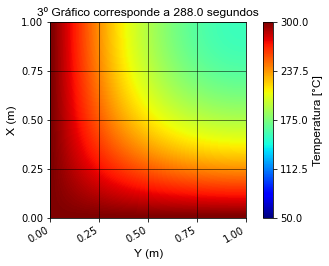

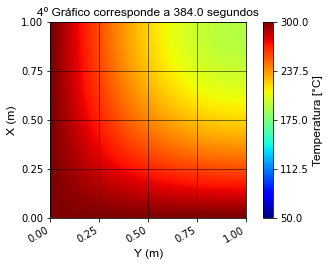

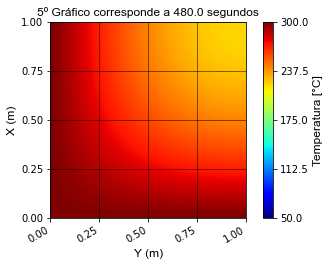

In [46]:

#fonte dos gráficos
matplot_font = {'fontname': 'Arial',
                'color':  'black',
                'weight': 'normal',
                'size': 12,
                }

for n in range(1,len(Domt)):
    surf = plt.imshow(Sol_T[:,:,n], interpolation='quadric', origin='lower',
             cmap=cm.jet, extent=(DomX.min(), DomX.max(), DomY.min(), DomY.max()))

    ColorBarTicks = np.linspace(Sol_T.min(),Sol_T.max(),5)
    
    cbar = plt.colorbar(surf, shrink=1.0, aspect=20, ticks=ColorBarTicks)
    
    #legenda da barra lateral
    
    cbar.set_label('Temperatura [°C]',fontdict=matplot_font)
    plt.title(str(n) + "º Gráfico corresponde a " + '{}'.format(np.around(Domt[n],2)) + " segundos", fontdict=matplot_font)
    plt.ylabel("X (m)",fontdict=matplot_font) 
    plt.xlabel("Y (m)",fontdict=matplot_font) 
    
    
    plt.grid(color='black', linestyle='solid', linewidth=0.5)

    labx = Dom_h(DomX[0],DomX[-1],5)[0]
    laby = Dom_h(DomY[0],DomY[-1],5)[0]
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()
    plt.clim(Sol_T.min(),Sol_T.max())
    
    #plt.text(0.5, -0.3, 'Condução de calor bidimensional transiente com geração de calor', ha='center', va='top',fontdict=matplot_font);

    plt.show()


##### Solução analítica: PROBLEMAS COM A SOLUÇÃO PARTICULAR

$$\frac{1}{\alpha}\frac{\partial T(x,y,t)}{\partial t} = \nabla^2 T(x,y,t) + \frac{G}{K} $$

$$ T(x,y,t) = T_h +T_p $$

$$ T(x,y,t) = \sum_{j = 1}^{\infty} \sum_{i = 1}^{\infty} \frac{1}{N_i N_j} \: \overline{f_{ij}} \: X_i Y_j \: e^{-\alpha (\beta_i^2 + \nu_j^2)t} \; , \;\;\;\;\; \overline{f_{ij}} = \int_0^{L_y} \int_0^{L_x} X_i Y_j f(x,y) dxdy$$

onde $f(x,y)$ é condição inicial $T(x,y,t=0)$

In [7]:
import scipy.integrate

def sol_analitica(alpha,Q,Tto,Txo,Tyo,X,Y,tempo,Lx,Ly,somaX,somaY):   #Q = G/K
  
  Sol_analitica = np.empty((len(X),len(Y),len(tempo)))

  for k,t in enumerate(tempo[1:], start=1):
    for j,y in enumerate(Y[1:], start=1):
      for i,x in enumerate(X[1:], start=1):
        
        #sol_particular = 0
        #sol_particular = 300
        #sol_particular = ((Q/4)*X[x]**2 + (Q/4)*Y[y]**2) + 300
        #sol_particular = Q*alpha*tempo[t] + Tto

        #T = sol_particular
        
        T = 0
        
        for n in range(1,somaY+1):
          for m in range(1,somaX+1):
            
            autofuncoes = lambda yaf, xaf : np.sin(((1/2 + 2*m)*np.pi/Lx)*xaf)*np.sin(((1/2 + 2*n)*np.pi/Ly)*yaf)*Tto   #Sempre defina y primeiro, é da sintaxe

            f_barra = scipy.integrate.dblquad(autofuncoes,0,Ly,0,Lx)[0]
        
            T = T + (2/Lx)*(2/Ly)*f_barra*np.sin(((1/2 + 2*m)*np.pi/Lx)*x)*np.sin(((1/2 + 2*n)*np.pi/Ly)*y)*np.exp(-alpha*(((1/2 + 2*m)*np.pi/Lx)**2 + ((1/2 + 2*n)*np.pi/Ly)**2)*t)

        Sol_analitica[i,j,k] = T

  Sol_analitica[:,:,0] = np.ones((len(X),len(Y)))*Tto
  Sol_analitica[:,0,:] = np.ones((len(X),len(tempo)))*Txo
  Sol_analitica[0,:,:] = np.ones((len(Y),len(tempo)))*Tyo

  return Sol_analitica


In [4]:
'''
import scipy.integrate

def sol_analitica(alpha,Q,Tto,Txo,Tyo,X,Y,tempo,Lx,Ly,somaX,somaY):   #Q = G/K
  
  Sol_analitica = np.empty((len(X),len(Y),len(tempo)))

  T = 0
 
  for k,t in enumerate(tempo[1:], start=1):
    for j,y in enumerate(Y[1:], start=1):
      for i,x in enumerate(X[1:], start=1):
        
            T = Tto*math.erf(x/(np.sqrt(4*alpha*t)))*math.erf(y/(np.sqrt(4*alpha*t)))

            Sol_analitica[i,j,k] = T

  Sol_analitica[:,:,0] = np.ones((len(X),len(Y)))*Tto
  Sol_analitica[:,0,:] = np.ones((len(Y),len(tempo)))*Txo
  Sol_analitica[0,:,:] = np.ones((len(X),len(tempo)))*Tyo

  return Sol_analitica
  '''

In [8]:
#Parâmetros: alpha, Q, Tto, Txo, Tyo, X, Y, tempo, Lx, Ly, somaX, somaY    #Onde Q = G/K

DomX, hx = Dom_h(0, 1, 10)
DomY, hy = Dom_h(0, 1, 10)
Domt, ht = Dom_h(0, 120, 4)

#Sol_T_anali = sol_analitica(0.0008,20*10**3/34,300,300,300,DomX, DomY, Domt, 1, 1, 8, 8)
Sol_T_anali = sol_analitica(0.0008,0,50,300,300,DomX, DomY, Domt, 1, 1, 8, 8)

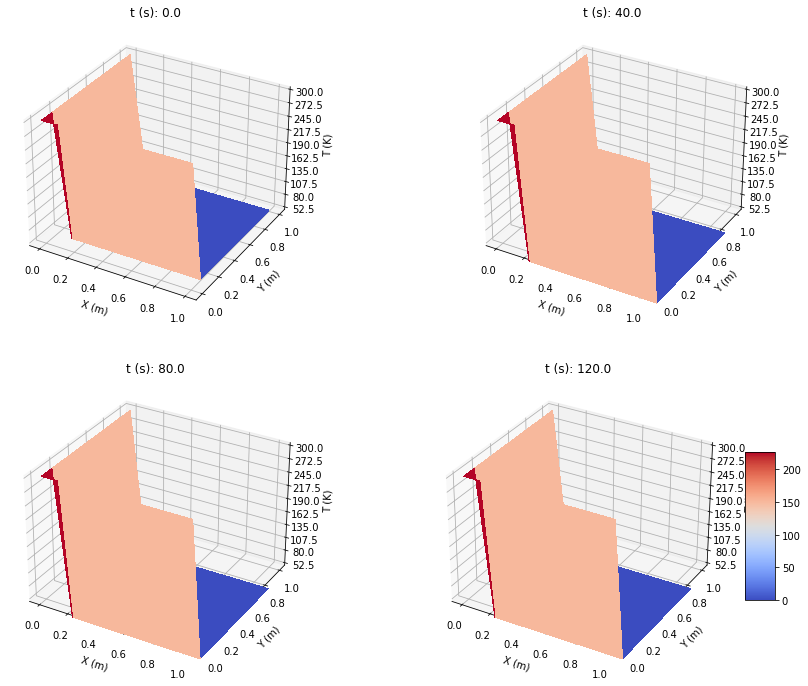

In [16]:

X, Y = np.meshgrid(DomX, DomY)

# Plot the surface.

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15,12), subplot_kw={"projection": "3d"})

surf1 = ax1.plot_surface(X, Y, Sol_T_anali[:,:,0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
surf2 = ax2.plot_surface(X, Y, Sol_T_anali[:,:,1], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
surf3 = ax3.plot_surface(X, Y, Sol_T_anali[:,:,2], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
surf4 = ax4.plot_surface(X, Y, Sol_T_anali[:,:,3], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customizing graphics

ax1.set_title('t (s): {}'.format(np.around(Domt[0],2)))
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_zlabel('T (K)')

ax2.set_title('t (s): {}'.format(np.around(Domt[1],2)))
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.set_zlabel('T (K)')

ax3.set_title('t (s): {}'.format(np.around(Domt[2],2)))
ax3.set_xlabel('X (m)')
ax3.set_ylabel('Y (m)')
ax3.set_zlabel('T (K)')

ax4.set_title('t (s): {}'.format(np.around(Domt[3],2)))
ax4.set_xlabel('X (m)')
ax4.set_ylabel('Y (m)')
ax4.set_zlabel('T (K)')

# Customizing the z axis.
ax1.zaxis.set_major_locator(LinearLocator(10))
ax1.set_zlim(Sol_T_anali[-1,-1,0] + 0.05*Sol_T_anali[-1,-1,0], 300)
ax2.zaxis.set_major_locator(LinearLocator(10))
ax2.set_zlim(Sol_T_anali[-1,-1,0] + 0.05*Sol_T_anali[-1,-1,0], 300)
ax3.zaxis.set_major_locator(LinearLocator(10))
ax3.set_zlim(Sol_T_anali[-1,-1,0] + 0.05*Sol_T_anali[-1,-1,0], 300)
ax4.zaxis.set_major_locator(LinearLocator(10))
ax4.set_zlim(Sol_T_anali[-1,-1,0] + 0.05*Sol_T_anali[-1,-1,0], 300)
ax5.zaxis.set_major_locator(LinearLocator(10))
ax5.set_zlim(Sol_T_anali[-1,-1,0] + 0.05*Sol_T_anali[-1,-1,0], 300)
ax6.zaxis.set_major_locator(LinearLocator(10))
ax6.set_zlim(Sol_T_anali[-1,-1,0] + 0.05*Sol_T_anali[-1,-1,0], 300)

# Add a color bar which maps values to colors.
fig.colorbar(surf4, shrink=0.5, aspect=5)

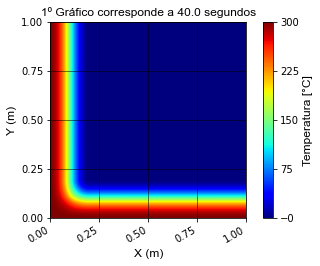

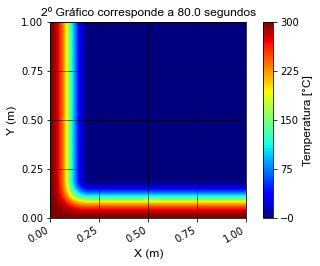

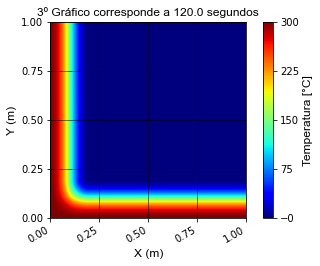

In [17]:
#fonte dos gráficos
matplot_font = {'fontname': 'Arial',
                'color':  'black',
                'weight': 'normal',
                'size': 12,
                }

for n in range(1,len(Domt)):
    surf = plt.imshow(Sol_T_anali[:,:,n], interpolation='quadric', origin='lower',
             cmap=cm.jet, extent=(DomX.min(), DomX.max(), DomY.min(), DomY.max()))

    ColorBarTicks = np.linspace(Sol_T_anali.min(),Sol_T_anali.max(),5)
    
    cbar = plt.colorbar(surf, shrink=1.0, aspect=20, ticks=ColorBarTicks)
    
    #legenda da barra lateral
    
    cbar.set_label('Temperatura [°C]',fontdict=matplot_font)
    plt.title(str(n) + "º Gráfico corresponde a " + '{}'.format(np.around(Domt[n],2)) + " segundos", fontdict=matplot_font)
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    
    
    plt.grid(color='black', linestyle='solid', linewidth=0.5)

    labx = Dom_h(DomX[0],DomX[-1],5)[0]
    laby = Dom_h(DomY[0],DomY[-1],5)[0]
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()
    plt.clim(Sol_T_anali.min(),Sol_T_anali.max())
    
    #plt.text(0.5, -0.3, 'teste', ha='center', va='top',fontdict=matplot_font)
    
    plt.show()

In [18]:
'''
import scipy.integrate

def sol_analitica_estacionaria(alpha,Q,Txo,Tyo,X,Y,Lx,Ly,somaX,somaY):   #Q = G/K
 
  Sol_analitica = np.empty((len(X),len(Y)))

  for j,y in enumerate(Y[1:], start=1):
    for i,x in enumerate(X[1:], start=1):
      
      #sol_particular = 0
      #sol_particular = 300
      #sol_particular = ((Q/4)*X[x]**2 + (Q/4)*Y[y]**2) + 300
      #sol_particular = Q*alpha*tempo[t] + Tto

      #T = sol_particular
      T = 0
      
      for n in range(1,somaY+1):
        for m in range(1,somaX+1):
          
          autofuncoes = lambda yaf, xaf : np.sin(((1/2 + 2*m)*np.pi/Lx)*xaf)*np.sin(((1/2 + 2*n)*np.pi/Ly)*yaf)   #Sempre defina y primeiro, é da sintaxe

          f_barra = scipy.integrate.dblquad(autofuncoes,0,Ly,0,Lx)[0]
      
          T = T + (2/Lx)*(2/Ly)*f_barra*np.sin(((1/2 + 2*m)*np.pi/Lx)*x)*np.sin(((1/2 + 2*n)*np.pi/Ly)*y)

      Sol_analitica[i,j] = T

  Sol_analitica[:,0] = np.ones(len(X))*Txo
  Sol_analitica[0,:] = np.ones(len(Y))*Tyo

  return Sol_analitica
'''

In [ ]:
'''
import scipy.integrate

def sol_analitica_estacionaria(alpha,Q,To,Txo,Tyo,X,Y,Lx,Ly,somaX,somaY):   #Q = G/K
 
  Sol_analitica = np.empty((len(X),len(Y)))

  for j,y in enumerate(Y[1:], start=1):
    for i,x in enumerate(X[1:], start=1):
      
      T = 0
      
      for n in range(1,somaY+1):
        for m in range(1,somaX+1):

          C = T
      
          T = T + (2/Lx)*(2/Ly)*f_barra*np.sin((m*np.pi/Lx)*x)*np.sin((n*np.pi/Ly)*y)

      Sol_analitica[i,j] = T

  Sol_analitica[:,0] = np.ones(len(X))*Txo
  Sol_analitica[0,:] = np.ones(len(Y))*Tyo

  return Sol_analitica
  '''

In [19]:
#Parâmetros: alpha, Q, Txo, Tyo, X, Y, Lx, Ly, somaX, somaY    #Onde Q = G/K

DomX, hx = Dom_h(0, 1, 10)
DomY, hy = Dom_h(0, 1, 10)

Sol_T_anali_estacionaria = sol_analitica_estacionaria(0.0008,0,300,300,DomX, DomY, 1, 1, 10, 10)

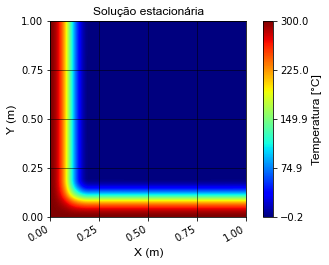

In [21]:
#fonte dos gráficos
matplot_font = {'fontname': 'Arial',
                'color':  'black',
                'weight': 'normal',
                'size': 12,
                }

surf = plt.imshow(Sol_T_anali_estacionaria, interpolation='quadric', origin='lower',
            cmap=cm.jet, extent=(DomX.min(), DomX.max(), DomY.min(), DomY.max()))

ColorBarTicks = np.linspace(Sol_T_anali_estacionaria.min(),Sol_T_anali_estacionaria.max(),5)

cbar = plt.colorbar(surf, shrink=1.0, aspect=20, ticks=ColorBarTicks)

#legenda da barra lateral

cbar.set_label('Temperatura [°C]',fontdict=matplot_font)
plt.title("Solução estacionária", fontdict=matplot_font)
plt.ylabel("Y (m)",fontdict=matplot_font) 
plt.xlabel("X (m)",fontdict=matplot_font) 


plt.grid(color='black', linestyle='solid', linewidth=0.5)

labx = Dom_h(DomX[0],DomX[-1],5)[0]
laby = Dom_h(DomY[0],DomY[-1],5)[0]
plt.xticks(labx)
plt.yticks(laby)
plt.gcf().autofmt_xdate()
plt.clim(Sol_T_anali_estacionaria.min(),Sol_T_anali_estacionaria.max())

#plt.text(0.5, -0.3, 'teste', ha='center', va='top',fontdict=matplot_font)

plt.show()

In [12]:
print(Sol_T_anali[0:7,0:7,0])
print(Sol_T_anali[0:7,0:7,2])
print(Sol_T_anali[0:7,0:7,-1])

[[300. 300. 300. 300. 300. 300. 300.]
 [300.  50.  50.  50.  50.  50.  50.]
 [300.  50.  50.  50.  50.  50.  50.]
 [300.  50.  50.  50.  50.  50.  50.]
 [300.  50.  50.  50.  50.  50.  50.]
 [300.  50.  50.  50.  50.  50.  50.]
 [300.  50.  50.  50.  50.  50.  50.]]
[[ 3.00000000e+02  3.00000000e+02  3.00000000e+02  3.00000000e+02
   3.00000000e+02  3.00000000e+02  3.00000000e+02]
 [ 3.00000000e+02  7.08593748e-04  9.10855199e-04  4.62379124e-04
  -3.16336691e-04 -8.69053735e-04 -8.00992619e-04]
 [ 3.00000000e+02  9.10855199e-04  1.17085029e-03  5.94360916e-04
  -4.06632037e-04 -1.11711699e-03 -1.02962846e-03]
 [ 3.00000000e+02  4.62379124e-04  5.94360916e-04  3.01716541e-04
  -2.06419380e-04 -5.67084181e-04 -5.22672218e-04]
 [ 3.00000000e+02 -3.16336691e-04 -4.06632037e-04 -2.06419380e-04
   1.41221825e-04  3.87970658e-04  3.57586212e-04]
 [ 3.00000000e+02 -8.69053735e-04 -1.11711699e-03 -5.67084181e-04
   3.87970658e-04  1.06584964e-03  9.82376191e-04]
 [ 3.00000000e+02 -8.00992619e-